<a href="https://colab.research.google.com/github/YUFULEO/Data-Representations-and-Clustering/blob/main/ECE219_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Clustering on Text Data

In [ ]:
!pip install umap-learn
!pip install hdbscan

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans

import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import hdbscan

import warnings
warnings.filterwarnings('ignore')

import gc
import time

In [ ]:
comp_categories = [ 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
twenty_dataset = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, remove=('headers', 'footers'), shuffle=True, random_state=42,)
true_labels = np.array([0 if x in [0, 1, 2, 3] else 1 for x in twenty_dataset.target])

### plotmat helper function

In [ ]:
def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)

    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%.3f", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="center",
    #              color="white" if mat[i, j] > thresh else "black")

    plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

### Question 1: Generate sparse TF-IDF representations


In [ ]:
min_df = 3
count_vect = CountVectorizer(min_df = min_df, stop_words='english')
X_counts = count_vect.fit_transform(twenty_dataset.data)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(7882, 23522)


**<font color=blue size=4>Question 1**

**- Report the dimensions of the TF-IDF matrix you obtain.**

The dimension of the TF-IDF matrix is (7882, 23522).

### Question 2 & 3: Clustering

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, max_iter = 1000, n_init = 30)
kmeans.fit(X_tfidf)

KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

In [ ]:
cluster_results = kmeans.labels_
cm = contingency_matrix(labels_true=true_labels, labels_pred=cluster_results)

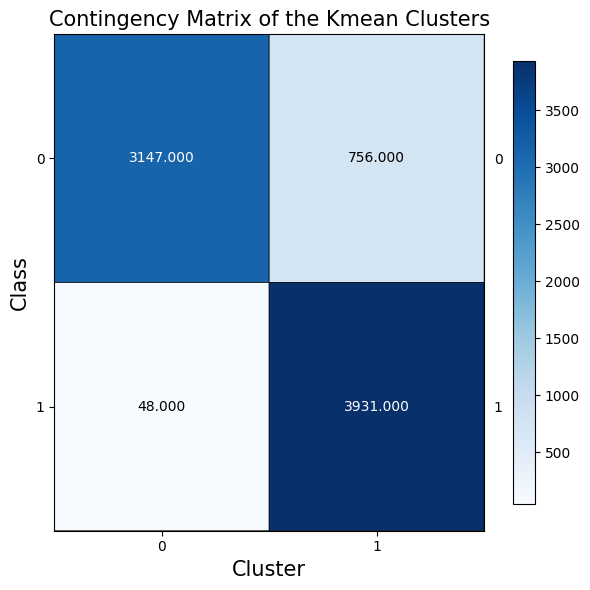

In [ ]:
plot_mat(cm, size = (6, 6), xlabel='Cluster', ylabel='Class', title='Contingency Matrix of the Kmean Clusters')

**<font color=blue size=4>Question 2**

**- Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to be square-shaped?**

You can see the contingency matrix above. And we use plotmat.py to visualize the matrix. In this case, the contingency matrix is usually be square-shaped. But in some cases it does not have to be square-shaped. If the number of clusters identified by the algorithm matches the number of true clusters, then the matrix will be square. However, sometimes the number of clusters identified by the algorithm will not matches the number of true clusters. And it does not have to be square-shaped.


In [ ]:
# five evaluation score
# Homogeneity is a measure of how “pure” the clusters are. If each cluster contains only data
# points from a single class, the homogeneity is satisfied.
print(f"homogeneity score: {homogeneity_score(labels_true=true_labels, labels_pred = cluster_results)}")

# Completeness indicates how much of the data points of a class are assigned to the same
# cluster.
print(f"completeness score: {completeness_score(labels_true=true_labels, labels_pred = cluster_results)}")

# V-measure is the harmonic average of homogeneity score and completeness score.
print(f"v-measure score: {v_measure_score(labels_true=true_labels, labels_pred = cluster_results)}")

# Adjusted Rand Index is similar to accuracy, which computes similarity between the clustering labels and ground truth labels. This method counts all pairs of points that both fall
# either in the same cluster and the same class or in different clusters and different classes.
print(f"adjusted rand score: {adjusted_rand_score(labels_true=true_labels, labels_pred = cluster_results)}")

# Adjusted mutual information score measures the mutual information between the cluster
# label distribution and the ground truth label distributions.
print(f"adjuested mutual score: {adjusted_mutual_info_score(labels_true=true_labels, labels_pred = cluster_results)}")

homogeneity score: 0.5753385457830721
completeness score: 0.5906592036944754
v-measure score: 0.5828982216461999
adjusted rand score: 0.6335554098420995
adjuested mutual score: 0.5828595337075382


**<font color=blue size=4>Question 3**

**- Report the 5 clustering measures explained in the introduction for Kmeans clustering.**

The 5 clustering measures are:

*   Homogeneity Score: 0.5753385457830721
*   Completeness Score: 0.5906592036944754
*   V-measure Score: 0.5828982216461999
*   Adjusted Rand Score: 0.6335554098420995
*   Adjuested Mutual Score: 0.5828595337075382






### Question 4-7: Clustering with Dense Text Representations

In [ ]:
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(X_tfidf)

TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

Text(0, 0.5, 'Percentage of Variance')

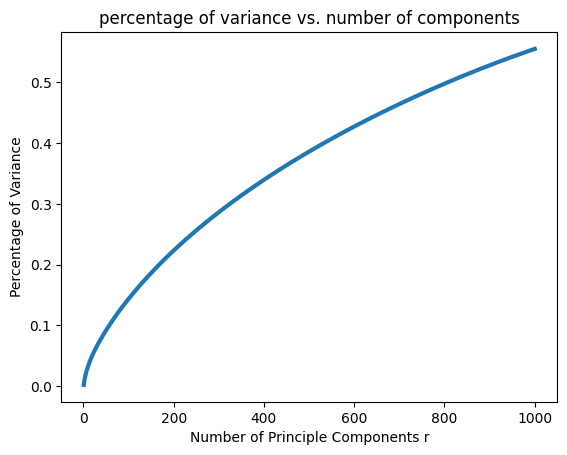

In [ ]:
#question 4
var_pct = []
for r in range(1, 1001):
  var_pct.append(svd.explained_variance_ratio_[:r].sum())
plt.plot(range(1, 1001), var_pct, linewidth = 3)
plt.title('percentage of variance vs. number of components')
plt.xlabel('Number of Principle Components r')
plt.ylabel('Percentage of Variance')

**<font color=blue size=4>Question 4**

**- Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.**

The image is shown above. We can found that when r increases, the percentage of variance will also increase.

In [ ]:
#question 5
r_ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
nmf_homogeneity_ls = []
nmf_completeness_ls = []
nmf_v_measure_ls = []
nmf_rand_ls = []
nmf_mutual_info_ls = []

for r in r_ls:
  nmf = NMF(n_components=r, init='random', random_state=0)
  X_reduced = nmf.fit_transform(X_tfidf)
  kmeans.fit(X_reduced)
  cluster_results = kmeans.labels_
  nmf_homogeneity_ls.append(homogeneity_score(labels_true=true_labels, labels_pred = cluster_results))
  nmf_completeness_ls.append(completeness_score(labels_true=true_labels, labels_pred = cluster_results))
  nmf_v_measure_ls.append(v_measure_score(labels_true=true_labels, labels_pred = cluster_results))
  nmf_rand_ls.append(adjusted_rand_score(labels_true=true_labels, labels_pred = cluster_results))
  nmf_mutual_info_ls.append(adjusted_mutual_info_score(labels_true=true_labels, labels_pred = cluster_results))

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
r_ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
svd_homogeneity_ls = []
svd_completeness_ls = []
svd_v_measure_ls = []
svd_rand_ls = []
svd_mutual_info_ls = []
kmeans = KMeans(n_clusters=2, random_state=0, max_iter = 1000, n_init = 30)
kmeans.fit(X_tfidf)
for r in r_ls:
  svd = TruncatedSVD(n_components=r, random_state=0)
  X_reduced = svd.fit_transform(X_tfidf)
  kmeans.fit(X_reduced)
  cluster_results = kmeans.labels_
  svd_homogeneity_ls.append(homogeneity_score(labels_true=true_labels, labels_pred = cluster_results))
  svd_completeness_ls.append(completeness_score(labels_true=true_labels, labels_pred = cluster_results))
  svd_v_measure_ls.append(v_measure_score(labels_true=true_labels, labels_pred = cluster_results))
  svd_rand_ls.append(adjusted_rand_score(labels_true=true_labels, labels_pred = cluster_results))
  svd_mutual_info_ls.append(adjusted_mutual_info_score(labels_true=true_labels, labels_pred = cluster_results))

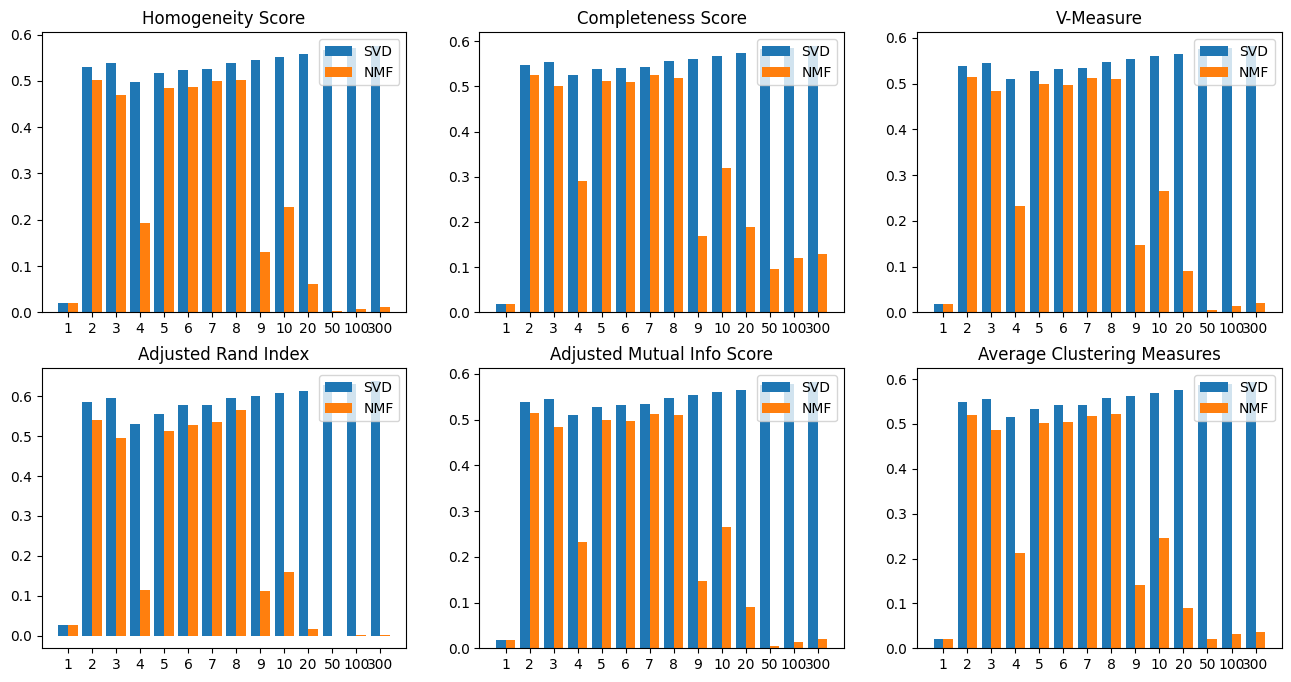

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

axs[0, 0].bar(np.arange(14)-0.2, svd_homogeneity_ls, 0.4, label = 'SVD')
axs[0, 0].bar(np.arange(14)+0.2, nmf_homogeneity_ls, 0.4, label = 'NMF')
axs[0, 0].set_title('Homogeneity Score')
axs[0, 0].set_xticks(np.arange(14), [str(r) for r in r_ls])
axs[0, 0].legend()

axs[0, 1].bar(np.arange(14)-0.2, svd_completeness_ls, 0.4, label = 'SVD')
axs[0, 1].bar(np.arange(14)+0.2, nmf_completeness_ls, 0.4, label = 'NMF')
axs[0, 1].set_title('Completeness Score')
axs[0, 1].set_xticks(np.arange(14), [str(r) for r in r_ls])
axs[0, 1].legend()

axs[0, 2].bar(np.arange(14)-0.2, svd_v_measure_ls, 0.4, label = 'SVD')
axs[0, 2].bar(np.arange(14)+0.2, nmf_v_measure_ls, 0.4, label = 'NMF')
axs[0, 2].set_title('V-Measure')
axs[0, 2].set_xticks(np.arange(14), [str(r) for r in r_ls])
axs[0, 2].legend()

axs[1, 0].bar(np.arange(14)-0.2, svd_rand_ls, 0.4, label = 'SVD')
axs[1, 0].bar(np.arange(14)+0.2, nmf_rand_ls, 0.4, label = 'NMF')
axs[1, 0].set_title('Adjusted Rand Index')
axs[1, 0].set_xticks(np.arange(14), [str(r) for r in r_ls])
axs[1, 0].legend()

axs[1, 1].bar(np.arange(14)-0.2, svd_mutual_info_ls, 0.4, label = 'SVD')
axs[1, 1].bar(np.arange(14)+0.2, nmf_mutual_info_ls, 0.4, label = 'NMF')
axs[1, 1].set_title('Adjusted Mutual Info Score')
axs[1, 1].set_xticks(np.arange(14), [str(r) for r in r_ls])
axs[1, 1].legend()

svd_average_score = np.mean([svd_completeness_ls, svd_homogeneity_ls,
                             svd_mutual_info_ls, svd_rand_ls, svd_v_measure_ls],
                             axis = 0)
nmf_average_score = np.mean([nmf_completeness_ls, nmf_homogeneity_ls,
                             nmf_mutual_info_ls, nmf_rand_ls, nmf_v_measure_ls],
                             axis = 0)
axs[1, 2].bar(np.arange(14)-0.2, svd_average_score, 0.4, label = 'SVD')
axs[1, 2].bar(np.arange(14)+0.2, nmf_average_score, 0.4, label = 'NMF')
axs[1, 2].set_title('Average Clustering Measures')
axs[1, 2].set_xticks(np.arange(14), [str(r) for r in r_ls])
axs[1, 2].legend()

plt.show()

**<font color=blue size=4>Question 5**

**- Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores vs r for both SVD and NMF.
Report a good choice of r for SVD and NMF respectively.**

We tried different values of r, such as 1-10, 20, 50, 100, 300. You can see the images above.

*   For SVD, r = 50.
*   For NMF, r = 2.



**<font color=blue size=4>Question 6**

**- How do you explain the non-monotonic behavior of the measures as r increases?**

At the very beginning, when r tends to zero, the clustering measure score is close to zero. As r gradually increases, the clustering measure score will increases. Because there are more information. However, when r reaches a critical value and is large enough, there are non-monotonic behavior of the measures, even though r continues to increase. The reason is it becomes high-dimensional space, and the Euclidean distance is not good at the high-dimensional space. In high-dimensional space, the distances between each points are almost the same, so the Euclidean distance is no longer effective. Therefore, the K-means algorithm, which group data points based on the distance between each others, are not effective.

In [ ]:
print('SVD with r = 50:')
print(f"Completeness score: {svd_completeness_ls[-3]}")
print(f"Homogeneity score: {svd_homogeneity_ls[-3]}")
print(f"V-measure: {svd_v_measure_ls[-3]}")
print(f"Adjusted rand score: {svd_rand_ls[-3]}")
print(f"Adjusted mutual info score: {svd_mutual_info_ls[-3]}")
print('----------------------------------------------')
print('NMF with r = 2:')
print(f"Completeness score: {nmf_completeness_ls[2]}")
print(f"Homogeneity score: {nmf_homogeneity_ls[2]}")
print(f"V-measure: {nmf_v_measure_ls[2]}")
print(f"Adjusted rand score: {nmf_rand_ls[2]}")
print(f"Adjusted mutual info score: {nmf_mutual_info_ls[2]}")

SVD with r = 50:
Completeness score: 0.5826140056290816
Homogeneity score: 0.5675836490766137
V-measure: 0.5750006217891473
Adjusted rand score: 0.6279119652859437
Adjusted mutual info score: 0.574961204114765
----------------------------------------------
NMF with r = 2:
Completeness score: 0.500375235543389
Homogeneity score: 0.47020342989998204
V-measure: 0.48482036617204083
Adjusted rand score: 0.494316445796442
Adjusted mutual info score: 0.48477173389863876


**<font color=blue size=4>Question 7**

**- Are these measures on average better than those computed in Question 3?**

For SVD with r = 50:

*   Homogeneity score: 0.5675836490766137
*   Completeness score: 0.5826140056290816
*   V-measure: 0.5750006217891473
*   Adjusted rand score: 0.6279119652859437
*   Adjuested Mutual Score: 0.574961204114765


For NMF with r = 2:

*   Homogeneity score: 0.47020342989998204
*   Completeness score: 0.500375235543389
*   V-measure: 0.48482036617204083
*   Adjusted rand score: 0.0.494316445796442
*   Adjuested Mutual Score: 0.48477173389863876

For sparse data:

*   Homogeneity Score: 0.5753385457830721
*   Completeness Score: 0.5906592036944754
*   V-measure Score: 0.5828982216461999
*   Adjusted Rand Score: 0.6335554098420995
*   Adjuested Mutual Score: 0.5828595337075382

According to the score above, we can find that these measures on average are not better than those computed in Question 3.

### Question 8 & 9: Visualiza the clusters

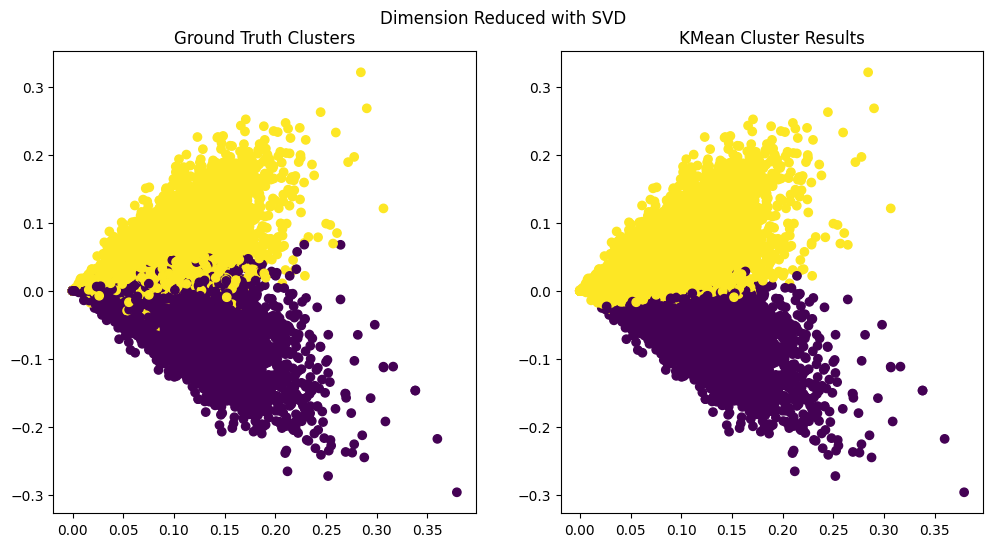

In [ ]:
best_svd_r = 50

svd = TruncatedSVD(n_components=best_svd_r, random_state=1)
X_svd_reduced = svd.fit_transform(X_tfidf)
kmeans = KMeans(n_clusters=2, random_state=0, max_iter = 1000, n_init = 30)
svd_cluster_results = kmeans.fit_predict(X_svd_reduced)
project_svd = TruncatedSVD(n_components=2, random_state=0)
X_svd_reduced_ = project_svd.fit_transform(X_svd_reduced)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(X_svd_reduced_[:, 0], X_svd_reduced_[:, 1], c=true_labels)

plt.title("Ground Truth Clusters")
plt.subplot(1,2,2)
plt.scatter(X_svd_reduced_[:, 0], X_svd_reduced_[:, 1], c=svd_cluster_results)
plt.title("KMean Cluster Results")

plt.suptitle("Dimension Reduced with SVD").set_y(0.95)
plt.show()

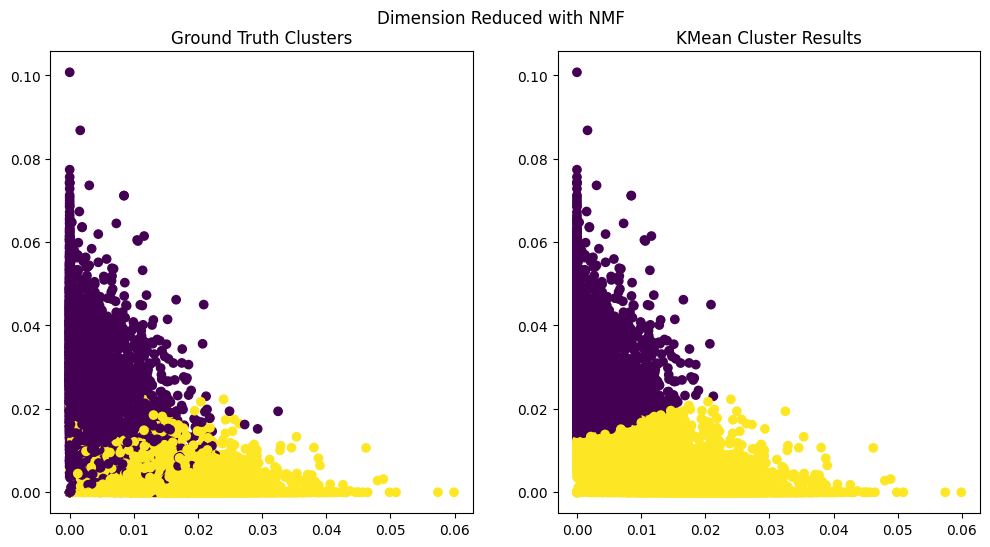

In [ ]:
best_nmf_r = 2  #no need to furthur projecting to 2-D

nmf = NMF(n_components=best_nmf_r, init='random', random_state=0)
X_nmf_reduced = nmf.fit_transform(X_tfidf)

kmeans = KMeans(n_clusters=2, random_state=3, max_iter = 1000, n_init = 30)
nmf_cluster_results = kmeans.fit_predict(X_nmf_reduced)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(X_nmf_reduced[:, 0], X_nmf_reduced[:, 1], c=true_labels)
plt.title("Ground Truth Clusters")

plt.subplot(1,2,2)
plt.scatter(X_nmf_reduced[:, 0], X_nmf_reduced[:, 1], c=nmf_cluster_results)
plt.title("KMean Cluster Results")

plt.suptitle("Dimension Reduced with NMF").set_y(0.95)
plt.show()

**<font color=blue size=4>Question 8**

**- Visualize the clustering results for:**

**- SVD with your optimal choice of r for K-Means clustering;**

**- NMF with your choice of r for K-Means clustering.**

For SVD, r = 50. For NMF, r = 2.

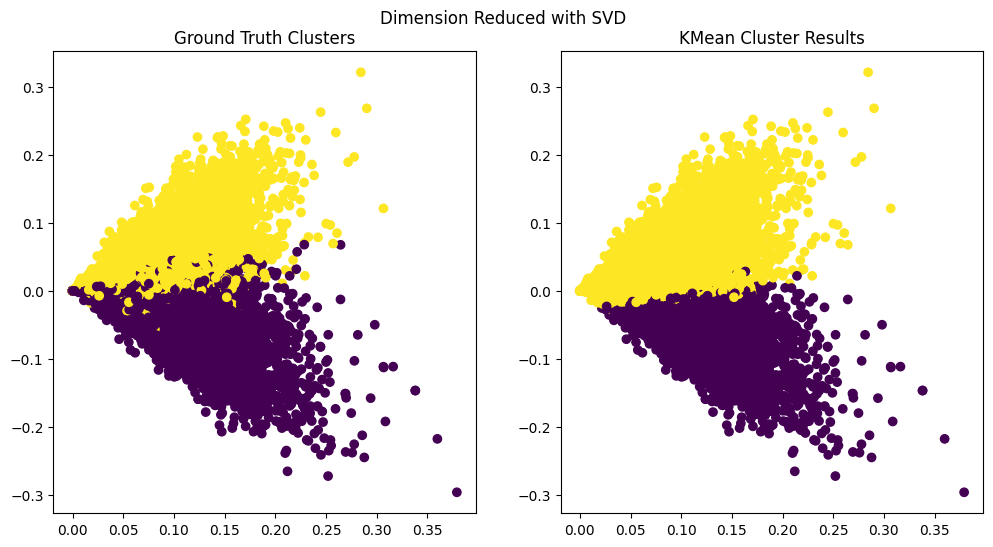

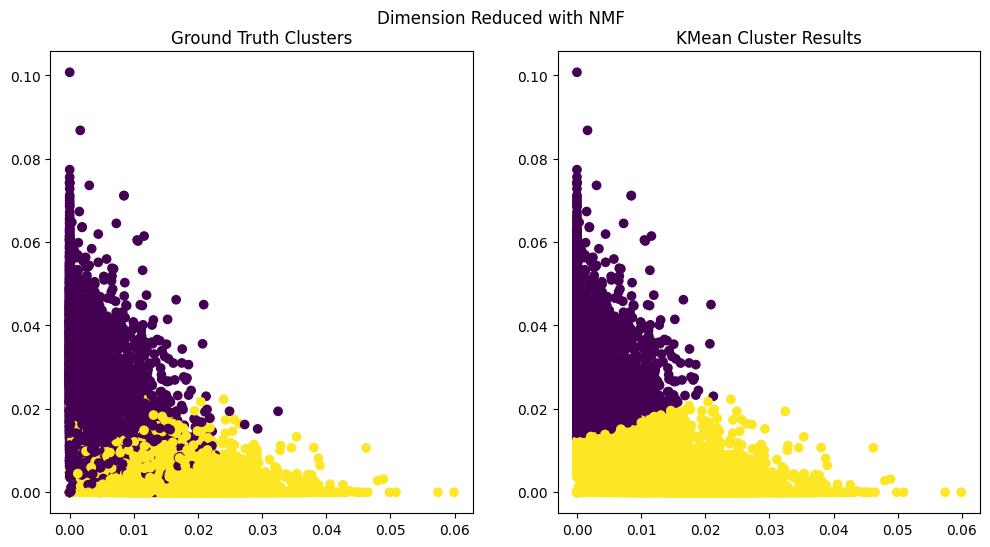

**<font color=blue size=4>Question 9**

**- What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?**

For SVD, we can find that the KMeans cluster results closely mirror the ground truth clusters, demonstrating that following dimensionality reduction with SVD, KMeans was able to distinguish the two groups with accuracy. The data points are distributed in a way that seems to be linearly separable, which means the clusters are distinct and well separated. The distribution of the data is ideal for K-Means clustering.

For NMF, we can find that there are still two classes. But the separation between them is less distinct compared to the SVD reduction. In contrast to the SVD results, the KMeans clustering results following NMF demonstrate that the algorithm had greater challenges in precisely distinguishing the clusters. Because the clusters in the instance of NMF do not appear to be as well separated, the distribution of the data is not ideal for KMeans.

### Question 10: Clustering the Entire 20 Classes

In [ ]:
all_twenty_dataset = fetch_20newsgroups(subset='all', categories=None, remove=('headers', 'footers'), shuffle=True, random_state=42)
true_labels_all = all_twenty_dataset.target

In [ ]:
min_df = 3
count_vect = CountVectorizer(min_df = min_df, stop_words='english')
X_counts_all = count_vect.fit_transform(all_twenty_dataset.data)

tfidf_transformer = TfidfTransformer()
X_tfidf_all = tfidf_transformer.fit_transform(X_counts_all)
print(X_tfidf_all.shape)

(18846, 45365)


In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X_reduced_all = svd.fit_transform(X_tfidf_all)
kmeans = KMeans(n_clusters=20, random_state=3, max_iter = 1000, n_init = 30)
kmeans.fit(X_reduced_all)
cluster_results_all = kmeans.labels_
cm = confusion_matrix(true_labels_all, cluster_results_all)
rows, cols = linear_sum_assignment(cm, maximize=True)

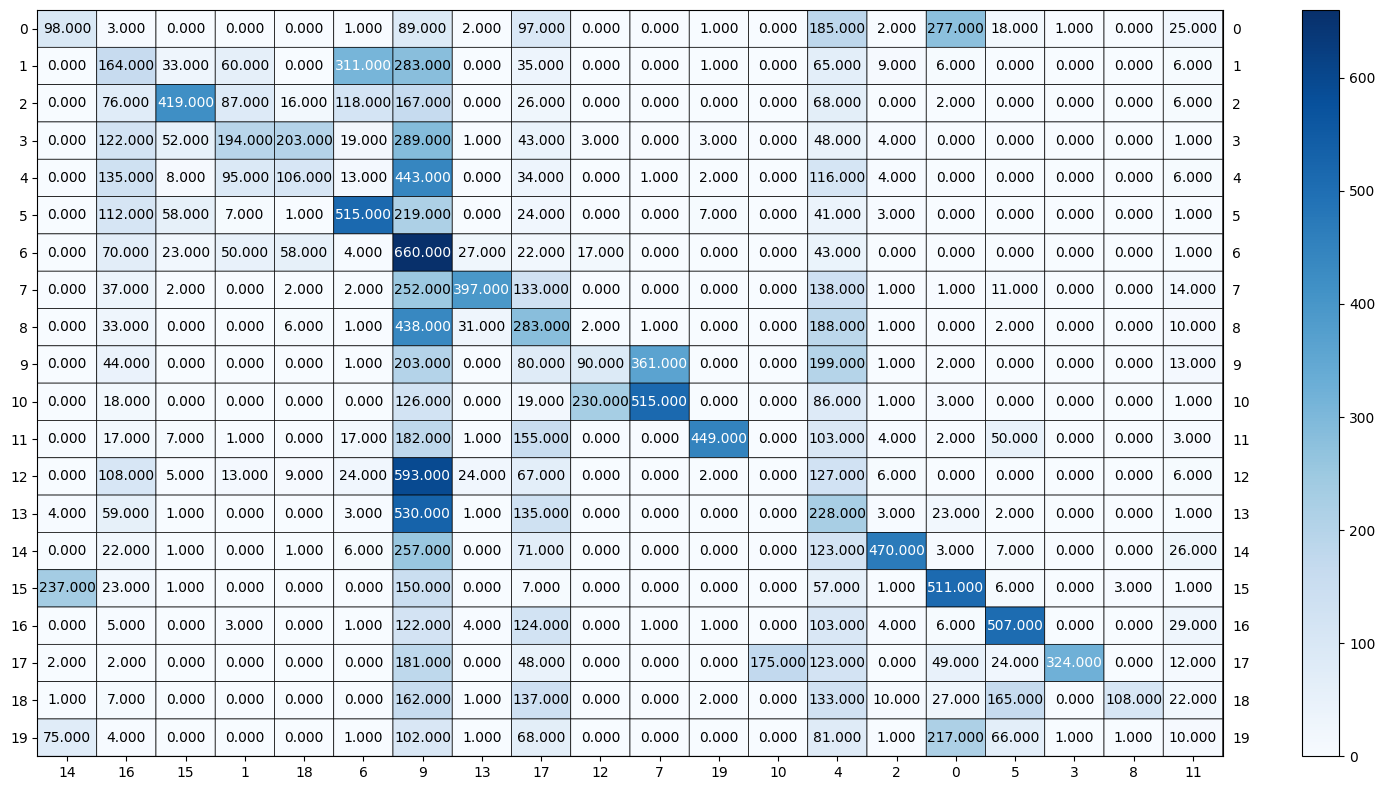

homogeneity score: 0.32677968821875963
completeness score: 0.38743682197137036
v-measure score: 0.3545325040289753
adjusted rand score: 0.10467362994798493
adjuested mutual score: 0.3522596565620435


In [ ]:
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(14,8))
print(f"homogeneity score: {homogeneity_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"completeness score: {completeness_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"v-measure score: {v_measure_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"adjusted rand score: {adjusted_rand_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"adjuested mutual score: {adjusted_mutual_info_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")

In [ ]:
nmf = NMF(n_components=2, init='random', random_state=42)
X_reduced_all = nmf.fit_transform(X_tfidf_all)
kmeans = KMeans(n_clusters=20, random_state=3, max_iter = 1000, n_init = 30)
kmeans.fit(X_reduced_all)
cluster_results_all = kmeans.labels_
cm = confusion_matrix(true_labels_all, cluster_results_all)
rows, cols = linear_sum_assignment(cm, maximize=True)

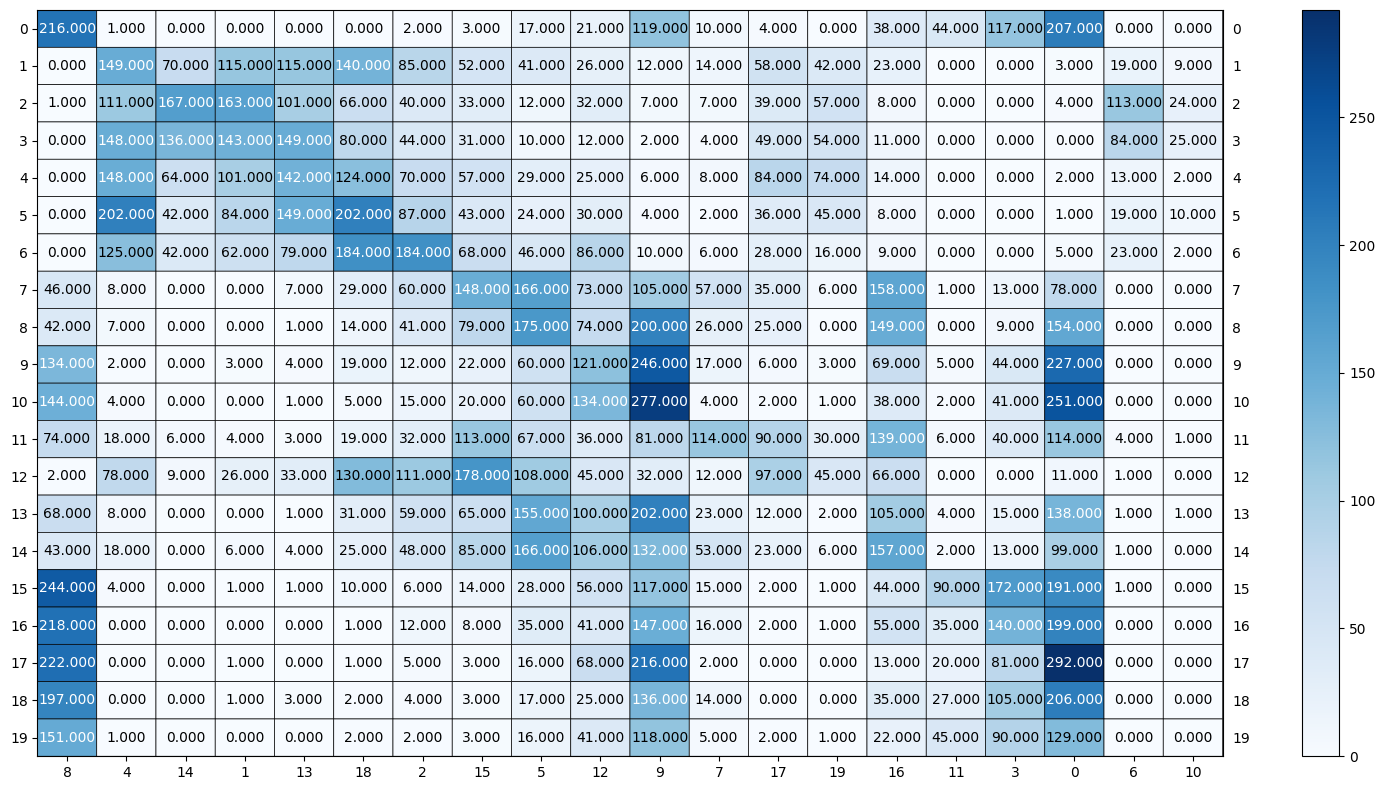

homogeneity score: 0.19171780881511732
completeness score: 0.20462568606947526
v-measure score: 0.19796155943951085
adjusted rand score: 0.05746664432937735
adjuested mutual score: 0.1952753544767217


In [ ]:
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(14,8))
print(f"homogeneity score: {homogeneity_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"completeness score: {completeness_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"v-measure score: {v_measure_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"adjusted rand score: {adjusted_rand_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")
print(f"adjuested mutual score: {adjusted_mutual_info_score(labels_true=true_labels_all, labels_pred = cluster_results_all)}")

**<font color=blue size=4>Question 10**

**- Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with k=20 . Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).**

According to the Question 5, we already found the best choice for the value of r. Therefore, in this question, for SVD, we choose r = 50. For NMF, we choose r = 2. And you can see the contingency matrix above. The five clustering metrics are below:



|           SVD        | r = 50 |
| ----------------  | ------   |
| homogeneity score      |   0.327   |    
| completeness score     |   0.387   |  
| v-measure score             | 0.355
| adjusted rand score             | 0.105
| adjuested mutual score            | 0.352

|           NMF        | r = 2 |
| ----------------  | ------   |
| homogeneity score      |   0.192   |    
| completeness score     |   0.205   |  
| v-measure score             | 0.198
| adjusted rand score             | 0.057
| adjuested mutual score            | 0.195

### Question 11 - 13: UMAP

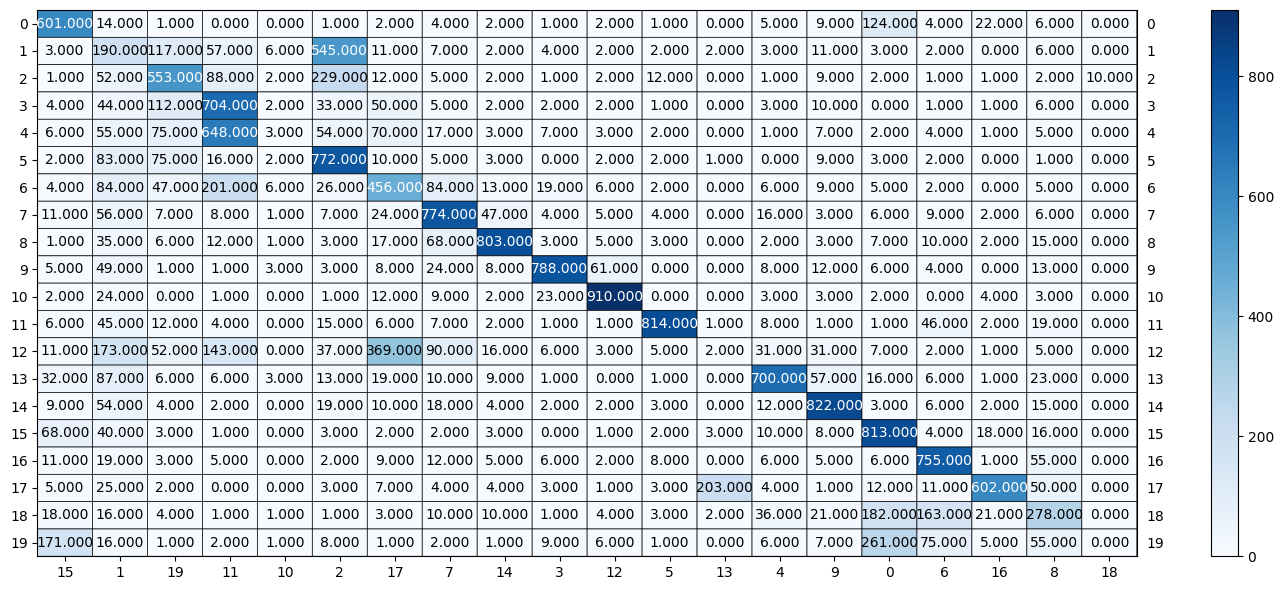

With n_components = 5, metric = cosine, homogeneity score: 0.5621410252809195
completeness score: 0.5937989379151183
v-measure score: 0.5775364714399379
adjusted rand score: 0.44549017193380586
adjuested mutual score: 0.5761213440110385


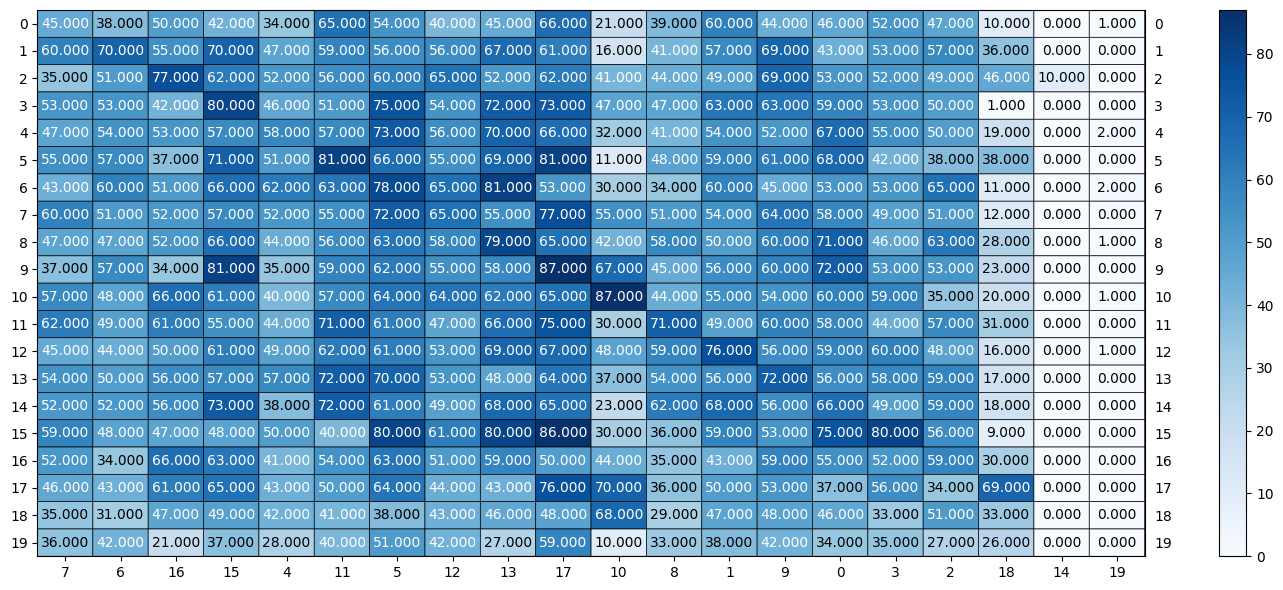

With n_components = 5, metric = euclidean, homogeneity score: 0.0076977886963619955
completeness score: 0.007998556335561874
v-measure score: 0.007845290916054253
adjusted rand score: 0.0010007508444674707
adjuested mutual score: 0.004586364677253119


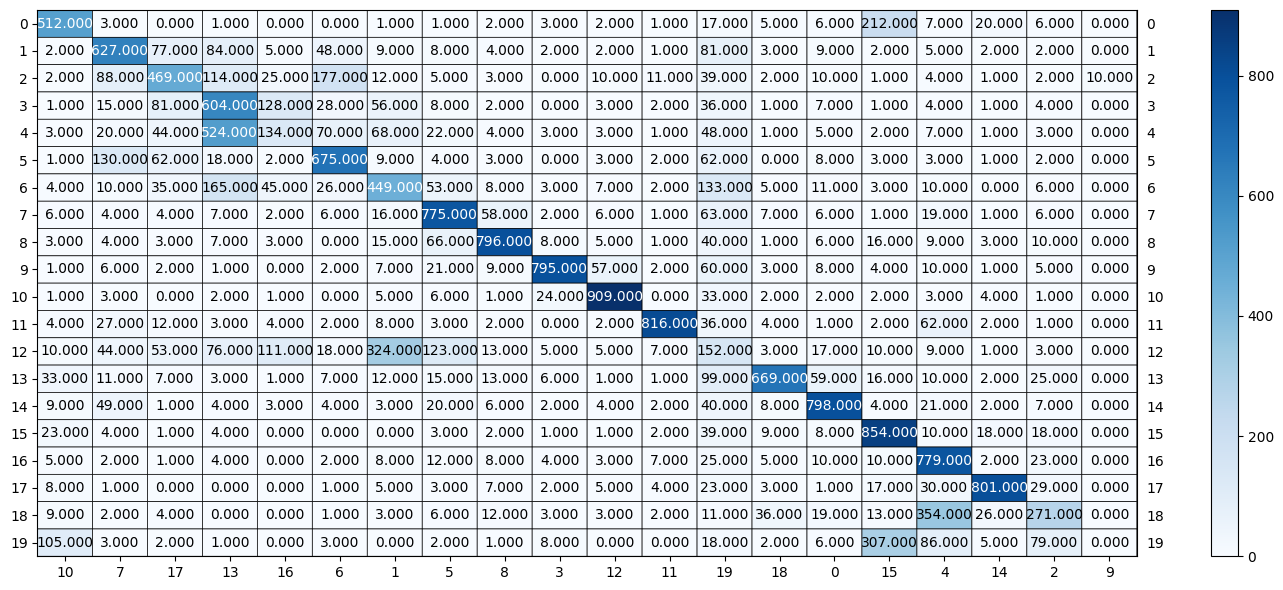

With n_components = 20, metric = cosine, homogeneity score: 0.5732694855172794
completeness score: 0.5900765147733965
v-measure score: 0.5815515933444613
adjusted rand score: 0.46326627075658144
adjuested mutual score: 0.5801798932875958


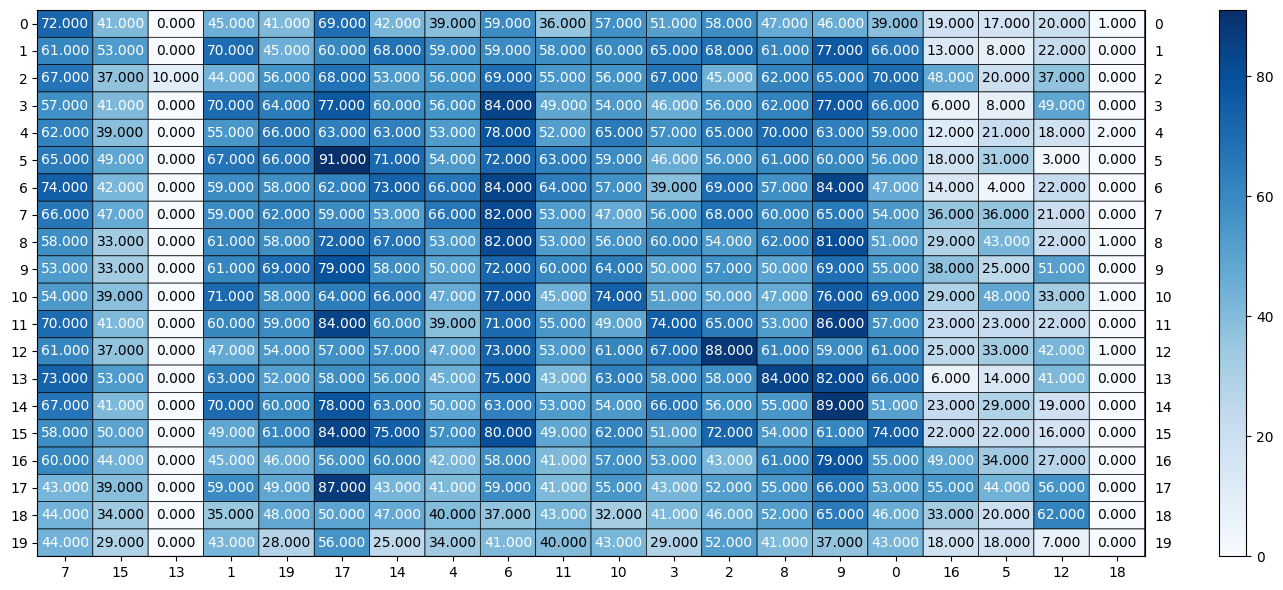

With n_components = 20, metric = euclidean, homogeneity score: 0.0076337038620950155
completeness score: 0.00798313228245666
v-measure score: 0.007804508822674117
adjusted rand score: 0.0008285367354293323
adjuested mutual score: 0.004551429049876107


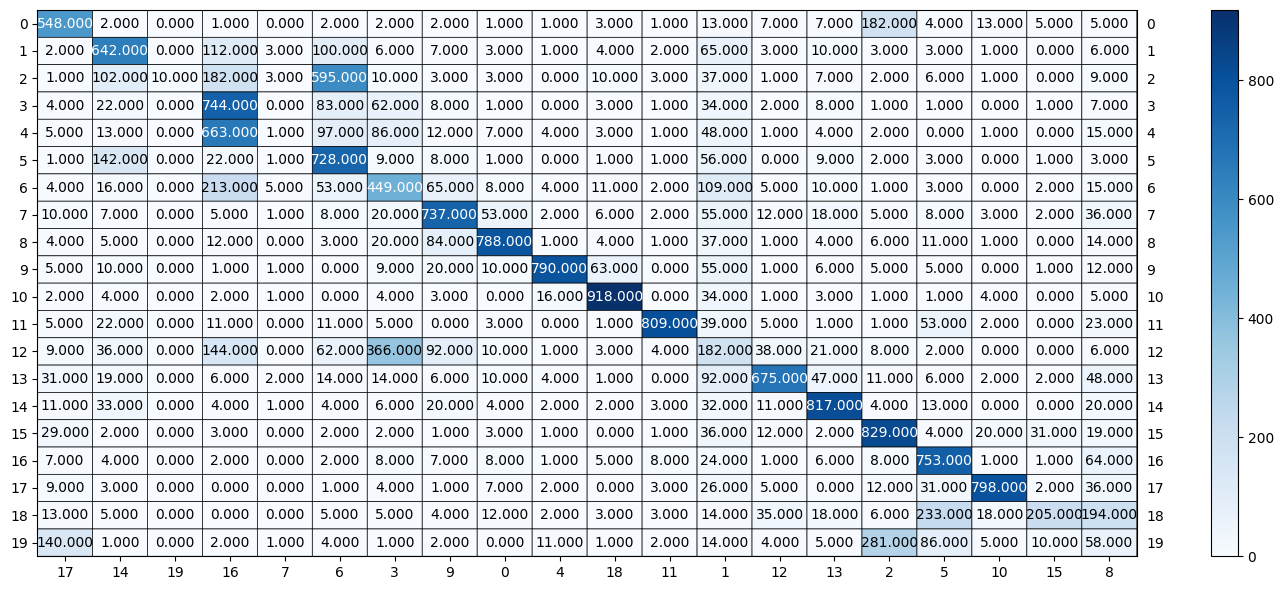

With n_components = 200, metric = cosine, homogeneity score: 0.5713238058280972
completeness score: 0.6043251802720695
v-measure score: 0.587361306023995
adjusted rand score: 0.4545133821210472
adjuested mutual score: 0.5859787484633572


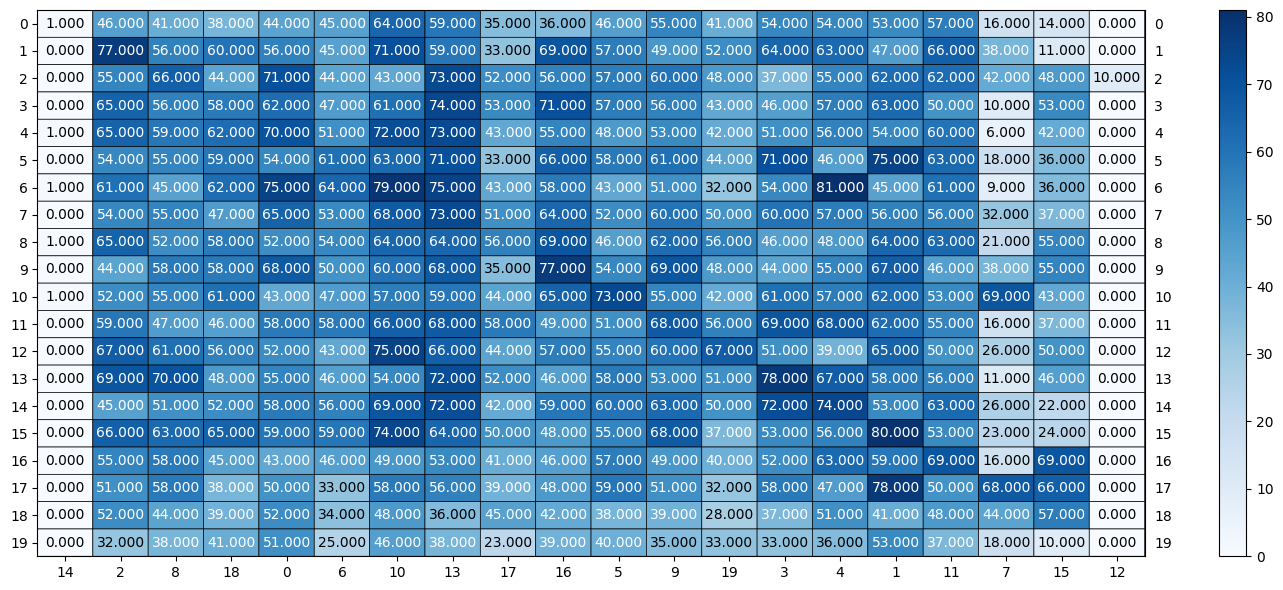

With n_components = 200, metric = euclidean, homogeneity score: 0.007007418530643639
completeness score: 0.0072744661312090396
v-measure score: 0.007138445656899898
adjusted rand score: 0.0008027581972486616
adjuested mutual score: 0.003906754066401182


In [ ]:
ns = [5, 20, 200]
ms = ['cosine', 'euclidean']
for n in ns:
  for m in ms:
    reducer = umap.UMAP(n_components = n, metric = m)
    umap_embedding = reducer.fit_transform(X_tfidf_all)
    kmeans = KMeans(n_clusters=20, random_state=42, max_iter = 1000, n_init = 30)
    kmeans.fit(umap_embedding)
    cluster_results = kmeans.labels_
    cm = confusion_matrix(true_labels_all, cluster_results)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(13,6))
    print(f"With n_components = {n}, metric = {m}, homogeneity score: {homogeneity_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
    print(f"completeness score: {completeness_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
    print(f"v-measure score: {v_measure_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
    print(f"adjusted rand score: {adjusted_rand_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
    print(f"adjuested mutual score: {adjusted_mutual_info_score(labels_true=true_labels_all, labels_pred = cluster_results)}")

**<font color=blue size=4>Question 11**

**- Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If cosine” metric fails, please look at the FAQ at the end of this spec.
Report the permuted contingency matrix and the five clustering evaluation metrics for the different combinations (6 combinations).**

We already report the permuted contingency matrix and the five clustering evaluation metrics for the different combinations. There are 6 combinations. Please see the them above. We tried

*   r=5(cosine)

*   r=5(euclidean)

*   r=20(cosine)
*   r=20(euclidean)


*   r=200(cosine)


*   r=200(euclidean)

**<font color=blue size=4>Question 12**

**- Analyze the contingency matrices. Which setting works best and why? What about for each metric choice?**

|   | homogeneity score |completeness score|v-measure score|adjusted rand score| adjuested mutual score
| ----------------  | ------   |------|------|------|------|
| r = 5 (cosine)|0.562|0.594 |0.578  |0.445 |0.576   
| r = 5 (euclidean)| 0.008|0.008|0.008|0.001|0.005
| r = 20 (cosine)| 0.573|0.590|0.582|0.463|0.580
| r = 20 (euclidean)| 0.008|0.008|0.008|0.001|0.005
| r = 200 (cosine)| 0.571|0.604|0.587|0.455|0.586
| r = 200 (euclidean)| 0.007  |0.007|0.007|0.001|0.004

According to the table above, we found that when r = 200 with cosine, it works best. You can see each metric in the table. More components have the ability to capture more of the data's variability. Having more components enables UMAP to provide a representation that can more effectively distinguish between the classes in cases when the data has a complex structure or multiple classes. There may be a loss of significance in the twenty components that distinguish the classes. Also, UMAP can distinguish between noise and the data's true structure more effectively with more components. A less accurate depiction can result from noise and structure being hard to differentiate when there are insufficient components. Also, the cosine distance adopted by UMAP will correctly identify similarity, whereas Euclidean distance might fail.

In [ ]:
#Question 13
cols = ['Homogeneity Score', 'Completeness Score', 'V-Measure', 'Adjusted Rand Score', 'Adjusted Mutual Score']
measures = []
sparse_tfidf = X_tfidf_all
pca_reduced = TruncatedSVD(n_components=50, n_iter=7, random_state=42).fit_transform(X_tfidf_all)
nmf_reduced = NMF(n_components=2, init='random', random_state=42).fit_transform(X_tfidf_all)
umap_reduced = umap.UMAP(n_components = 200, metric = 'cosine').fit_transform(X_tfidf_all)
for X in [sparse_tfidf, pca_reduced, nmf_reduced, umap_reduced]:
  kmeans = KMeans(n_clusters=20, random_state=42, max_iter = 1000, n_init = 30)
  kmeans.fit(X)
  cluster_results = kmeans.labels_
  measures.append([
      homogeneity_score(labels_true=true_labels_all, labels_pred = cluster_results),
      completeness_score(labels_true=true_labels_all, labels_pred = cluster_results),
      v_measure_score(labels_true=true_labels_all, labels_pred = cluster_results),
      adjusted_rand_score(labels_true=true_labels_all, labels_pred = cluster_results),
      adjusted_mutual_info_score(labels_true=true_labels_all, labels_pred = cluster_results)
                   ])

In [ ]:
q_13_df = pd.DataFrame(measures, columns = cols)
q_13_df['Data'] = pd.Series(['sparse TF-IDF representation', 'PCA-reduced', 'NMF-reduced', 'UMAP-reduced'])
q_13_df[['Data', 'Homogeneity Score',	'Completeness Score',	'V-Measure',	'Adjusted Rand Score', 'Adjusted Mutual Score']]

Data  Homogeneity Score  Completeness Score  \
0  sparse TF-IDF representation           0.334328            0.387916   
1                   PCA-reduced           0.319971            0.382091   
2                   NMF-reduced           0.190990            0.204323   
3                  UMAP-reduced           0.567700            0.595166   

   V-Measure  Adjusted Rand Score  Adjusted Mutual Score  
0   0.359134             0.108555               0.356903  
1   0.348283             0.102943               0.345978  
2   0.197431             0.056659               0.194746  
3   0.581109             0.441373               0.579722

**<font color=blue size=4>Question 13**

**- So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced).Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.**

We create a table to compare these 4 techniques according to the five clustering evaluation metrics on 20-class text data. You can see the table above. We found that UMAP have the best performance. So UMAP is best for the K-Means clustering task on the 20-class text data.


### Question 14 - 16: Clustering Algorithms that do not explicitly rely on the Gaussian distribution per cluster


In [ ]:
#Agglomerative Clustering
for linkage in ['ward', 'single']:
  reducer = umap.UMAP(n_components = 200, metric = 'cosine')
  umap_embedding = reducer.fit_transform(X_tfidf_all)
  clustering = AgglomerativeClustering(n_clusters = 20, linkage = linkage).fit(umap_embedding)
  cluster_results = clustering.labels_
  print(f"With metric = {linkage}, homogeneity score: {homogeneity_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"completeness score: {completeness_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"v-measure score: {v_measure_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"adjusted rand score: {adjusted_rand_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"adjuested mutual score: {adjusted_mutual_info_score(labels_true=true_labels_all, labels_pred = cluster_results)}")

With metric = ward, homogeneity score: 0.5691690342454073
completeness score: 0.5902725964759444
v-measure score: 0.5795287572496776
adjusted rand score: 0.4414194326378711
adjuested mutual score: 0.5781449359642717
With metric = single, homogeneity score: 0.01577808347113332
completeness score: 0.37289932846645923
v-measure score: 0.03027516675869013
adjusted rand score: 0.0004774461627315364
adjuested mutual score: 0.02564377891825744


**<font color=blue size=4>Question 14**

**- Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single”
linkage criteria.
Report the five clustering evaluation metrics for each case.**

You can see the five clustering evaluation metrics for each case. We found that when metric = ward, the performance better according to the five clustering evaluation metrics.


In [ ]:
#HDBSCAN
for size in [20, 100, 200]:
  reducer = umap.UMAP(n_components = 200, metric = 'cosine')
  umap_embedding = reducer.fit_transform(X_tfidf_all)
  hdb = hdbscan.HDBSCAN(min_cluster_size=size).fit(umap_embedding)
  cluster_results = hdb.labels_
  print(f"With min cluster size = {size}, homogeneity score: {homogeneity_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"completeness score: {completeness_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"v-measure score: {v_measure_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"adjusted rand score: {adjusted_rand_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
  print(f"adjuested mutual score: {adjusted_mutual_info_score(labels_true=true_labels_all, labels_pred = cluster_results)}")

With min cluster size = 20, homogeneity score: 0.4480712356777604
completeness score: 0.4629759036048345
v-measure score: 0.4554016499752133
adjusted rand score: 0.09643550395936556
adjuested mutual score: 0.4441328245950759
With min cluster size = 100, homogeneity score: 0.40669901684962034
completeness score: 0.6139077877102119
v-measure score: 0.4892691143789677
adjusted rand score: 0.21707198469554775
adjuested mutual score: 0.48833071633851605
With min cluster size = 200, homogeneity score: 0.4081572423627067
completeness score: 0.6023901342202769
v-measure score: 0.48660736093585566
adjusted rand score: 0.20159506160605858
adjuested mutual score: 0.48556800036084263


**<font color=blue size=4>Question 15**

**- Apply HDBSCAN on UMAP-transformed 20-category data.
Use min_cluster_size=100 .
Vary the min cluster size among 20, 100, 200 and report your findings in terms of the
five clustering evaluation metrics - you will plot the best contingency matrix in the
next question. Feel free to try modifying other parameters in HDBSCAN to get
better performance.**

According to the five clustering evaluation metrics, we found that when min_cluster_size=100, it has the best performance. When min_cluster_size=200, it has better performance than min_cluster_size=20.

In [ ]:
np.unique(cluster_results)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

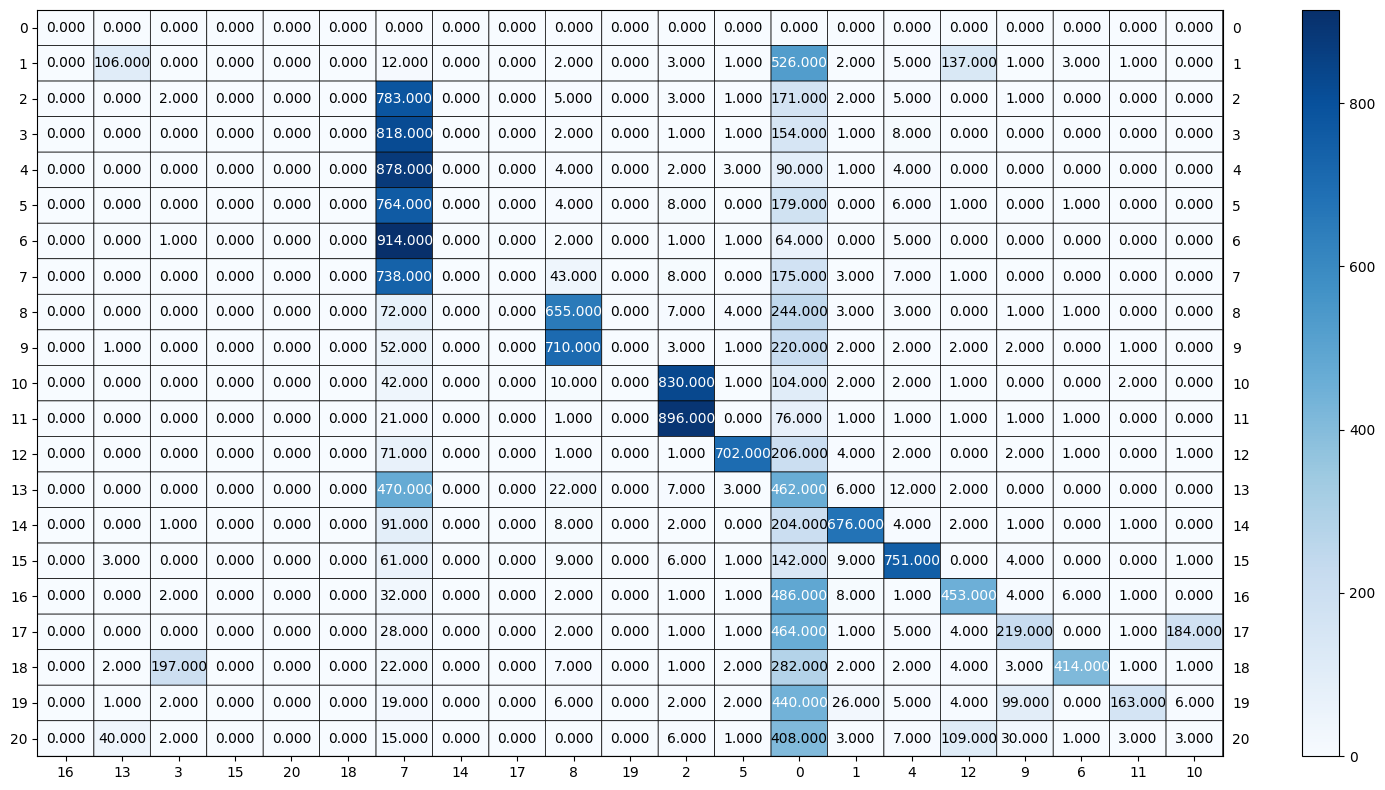

In [ ]:
reducer = umap.UMAP(n_components = 100, metric = 'cosine')
umap_embedding = reducer.fit_transform(X_tfidf_all)
hdb = hdbscan.HDBSCAN(min_cluster_size=100).fit(umap_embedding)
cluster_results = hdb.labels_
cm = confusion_matrix(true_labels_all, cluster_results)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(14,8))

**<font color=blue size=4>Question 16**

**- Contingency matrix**

**- Plot the contingency matrix for the best clustering model from Question 15.
How many clusters are given by the model? What does “-1” mean for the clustering labels?
Interpret the contingency matrix considering the answer to these questions.**

You can see the contingency matrix above. We found that there 14 clusters are given by the model. There are "-1" clustering labels. Generally, data points that the algorithm has categorized as "noise" are indicated by a label of "-1." These are points that don't quite fit into any of the clusters that have been discovered. In HDBSCAN, when interpreting the contingency matrix, "-1" can give you insight into how many points were not included in any clusters. In contrast to algorithms like K-Means that lack a mechanism for labeling noise, HDBSCAN is able to withstand noise and outliers more robustly because of this characteristic.



### Question 17

In [ ]:
#Question 17
config = {
        'None': {'model': None, 'params': [{}]},
        'SVD': {'model': TruncatedSVD, 'params': [{'n_components': r} for r in [5, 20, 200]]},
        'NMF': {'model': NMF, 'params': [{'n_components': r} for r in [5, 20, 200]]},
        'UMAP': {'model': umap.UMAP, 'params': [{'n_components': r, 'metric': 'cosine'} for r in [5, 20, 200]]}
}

q_17_df = pd.DataFrame(columns=['Dimensionality Reduction', 'DR Hyperparam', 'Clustering', 'CL Hyperparam', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Score', 'Adjusted Mutual Information'])


In [ ]:
start = time.time()
for dr_info, dr_param in config.items():
  for param in dr_param['params']:
    if dr_param['model'] is not None:
      dr_model = dr_param['model'](**param)
      print('Fitting ' + dr_info + ' with ', param)
      X_reduced = dr_model.fit_transform(X_tfidf_all)
      del dr_model
    else:
      X_reduced = X_tfidf_all
      param = {}
      print('Fitting no dimension reduction method...')

    #KMeans
    for k in [10, 20, 50]:
      kmeans = KMeans(n_clusters=k, random_state=3, max_iter = 1000, n_init = 30)
      print(f'Fitting KMeans with n_clusters = {k}')
      kmeans.fit(X_reduced)
      labels_pred = kmeans.labels_
      print('Finished fitting clustering')
      del kmeans
      # Compute evaluation metrics
      homogeneity = homogeneity_score(true_labels_all, labels_pred)
      completeness = completeness_score(true_labels_all, labels_pred)
      v_measure = v_measure_score(true_labels_all, labels_pred)
      adj_rand_score = adjusted_rand_score(true_labels_all, labels_pred)
      adj_mutual_info = adjusted_mutual_info_score(true_labels_all, labels_pred)
      q_17_df = q_17_df.append({
                      'Dimensionality Reduction': dr_info,
                      'DR Hyperparam': {**param},
                      'Clustering': 'KMeans',
                      'CL Hyperparam': k,
                      'Homogeneity': homogeneity,
                      'Completeness': completeness,
                      'V-measure': v_measure,
                      'Adjusted Rand Score': adj_rand_score,
                      'Adjusted Mutual Information': adj_mutual_info
                  }, ignore_index=True)
      del labels_pred, homogeneity, completeness, v_measure, adj_rand_score, adj_mutual_info
      gc.collect()
    gc.collect()
end = time.time()
print(end - start)

Fitting no dimension reduction method...
Fitting KMeans with n_clusters = 10
Finished fitting clustering
Fitting KMeans with n_clusters = 20
Finished fitting clustering
Fitting KMeans with n_clusters = 50
Finished fitting clustering
Fitting SVD with  {'n_components': 5}
Fitting KMeans with n_clusters = 10
Finished fitting clustering
Fitting KMeans with n_clusters = 20
Finished fitting clustering
Fitting KMeans with n_clusters = 50
Finished fitting clustering
Fitting SVD with  {'n_components': 20}
Fitting KMeans with n_clusters = 10
Finished fitting clustering
Fitting KMeans with n_clusters = 20
Finished fitting clustering
Fitting KMeans with n_clusters = 50
Finished fitting clustering
Fitting SVD with  {'n_components': 200}
Fitting KMeans with n_clusters = 10
Finished fitting clustering
Fitting KMeans with n_clusters = 20
Finished fitting clustering
Fitting KMeans with n_clusters = 50
Finished fitting clustering
Fitting NMF with  {'n_components': 5}
Fitting KMeans with n_clusters = 10


In [ ]:
#%%timeit
start = time.time()
for dr_info, dr_param in config.items():
  for param in dr_param['params']:
    if dr_param['model'] is not None:
      dr_model = dr_param['model'](**param)
      print('Fitting ' + dr_info + ' with ', param)
      X_reduced = dr_model.fit_transform(X_tfidf_all)
      del dr_model
    else:
      X_reduced = X_tfidf_all.toarray()
      param = {}
      print('Fitting no dimension reduction method...')

    #Agglomerative Clustering
    for n in [20]:
      print(f'Fitting Agglomerative Clustering with n_clusters = {n}')
      clustering = AgglomerativeClustering(n_clusters = n, linkage = 'ward').fit(X_reduced)
      labels_pred = clustering.labels_
      del clustering
      # Compute evaluation metrics
      homogeneity = homogeneity_score(true_labels_all, labels_pred)
      completeness = completeness_score(true_labels_all, labels_pred)
      v_measure = v_measure_score(true_labels_all, labels_pred)
      adj_rand_score = adjusted_rand_score(true_labels_all, labels_pred)
      adj_mutual_info = adjusted_mutual_info_score(true_labels_all, labels_pred)

      q_17_df = q_17_df.append({
                      'Dimensionality Reduction': dr_info,
                      'DR Hyperparam': {**param},
                      'Clustering': 'Agglomerative Clustering',
                      'CL Hyperparam': n,
                      'Homogeneity': homogeneity,
                      'Completeness': completeness,
                      'V-measure': v_measure,
                      'Adjusted Rand Score': adj_rand_score,
                      'Adjusted Mutual Information': adj_mutual_info
                  }, ignore_index=True)
      del labels_pred, homogeneity, completeness, v_measure, adj_rand_score, adj_mutual_info
      gc.collect()
    gc.collect()
end = time.time()
print(end - start)

Fitting no dimension reduction method...
Fitting Agglomerative Clustering with n_clusters = 20
Fitting SVD with  {'n_components': 5}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting SVD with  {'n_components': 20}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting SVD with  {'n_components': 200}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting NMF with  {'n_components': 5}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting NMF with  {'n_components': 20}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting NMF with  {'n_components': 200}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting UMAP with  {'n_components': 5, 'metric': 'cosine'}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting UMAP with  {'n_components': 20, 'metric': 'cosine'}
Fitting Agglomerative Clustering with n_clusters = 20
Fitting UMAP with  {'n_components': 200, 'metric': 'cosine'}
Fitting Agglomerative Clustering with n_clusters = 20
7888.

In [ ]:
#%%timeit
start = time.time()
for dr_info, dr_param in config.items():
  for param in dr_param['params']:
    if dr_param['model'] is not None:
      dr_model = dr_param['model'](**param)
      print('Fitting ' + dr_info + ' with ', param)
      X_reduced = dr_model.fit_transform(X_tfidf_all)
      del dr_model
    else:
      X_reduced = X_tfidf_all.toarray()
      param = {}
      print('Fitting no dimension reduction method...')

    #HDBSCAN
    for size in [100, 200]:
      print(f'Fitting HDBSCAN with min_cluster_size = {size}')
      hdb = hdbscan.HDBSCAN(min_cluster_size=size).fit(X_reduced)
      labels_pred = hdb.labels_
      del hdb
      # Compute evaluation metrics
      homogeneity = homogeneity_score(true_labels_all, labels_pred)
      completeness = completeness_score(true_labels_all, labels_pred)
      v_measure = v_measure_score(true_labels_all, labels_pred)
      adj_rand_score = adjusted_rand_score(true_labels_all, labels_pred)
      adj_mutual_info = adjusted_mutual_info_score(true_labels_all, labels_pred)

      q_17_df = q_17_df.append({
                      'Dimensionality Reduction': dr_info,
                      'DR Hyperparam': {**param},
                      'Clustering': 'HDBSCAN',
                      'CL Hyperparam': size,
                      'Homogeneity': homogeneity,
                      'Completeness': completeness,
                      'V-measure': v_measure,
                      'Adjusted Rand Score': adj_rand_score,
                      'Adjusted Mutual Information': adj_mutual_info
                  }, ignore_index=True)
      del labels_pred, homogeneity, completeness, v_measure, adj_rand_score, adj_mutual_info
      gc.collect()
    del X_reduced
    gc.collect()
end = time.time()
print(end - start)

Fitting SVD with  {'n_components': 5}
Fitting HDBSCAN with min_cluster_size = 100
Fitting HDBSCAN with min_cluster_size = 100
Fitting SVD with  {'n_components': 20}
Fitting HDBSCAN with min_cluster_size = 100
Fitting HDBSCAN with min_cluster_size = 100
Fitting SVD with  {'n_components': 200}
Fitting HDBSCAN with min_cluster_size = 100
Fitting HDBSCAN with min_cluster_size = 100
Fitting NMF with  {'n_components': 5}
Fitting HDBSCAN with min_cluster_size = 100
Fitting HDBSCAN with min_cluster_size = 100
Fitting NMF with  {'n_components': 20}
Fitting HDBSCAN with min_cluster_size = 100
Fitting HDBSCAN with min_cluster_size = 100
Fitting NMF with  {'n_components': 200}
Fitting HDBSCAN with min_cluster_size = 100
Fitting HDBSCAN with min_cluster_size = 100
Fitting UMAP with  {'n_components': 5, 'metric': 'cosine'}
Fitting HDBSCAN with min_cluster_size = 100
Fitting HDBSCAN with min_cluster_size = 100
Fitting UMAP with  {'n_components': 20, 'metric': 'cosine'}
Fitting HDBSCAN with min_cluste

In [ ]:
q_17_df

Dimensionality Reduction                              DR Hyperparam  \
0                      None                                         {}   
1                      None                                         {}   
2                      None                                         {}   
3                       SVD                        {'n_components': 5}   
4                       SVD                        {'n_components': 5}   
5                       SVD                        {'n_components': 5}   
6                       SVD                       {'n_components': 20}   
7                       SVD                       {'n_components': 20}   
8                       SVD                       {'n_components': 20}   
9                       SVD                      {'n_components': 200}   
10                      SVD                      {'n_components': 200}   
11                      SVD                      {'n_components': 200}   
12                      NMF                        {'n_components': 5}   
13                      NMF                        {'n_components': 5}   
14                      NMF                        {'n_components': 5}   
15                      NMF                       {'n_components': 20}   
16                      NMF                       {'n_components': 20}   
17                      NMF                       {'n_components': 20}   
18                      NMF                      {'n_components': 200}   
19                      NMF                      {'n_components': 200}   
20                      NMF                      {'n_components': 200}   
21                     UMAP    {'n_components': 5, 'metric': 'cosine'}   
22                     UMAP    {'n_components': 5, 'metric': 'cosine'}   
23                     UMAP    {'n_components': 5, 'metric': 'cosine'}   
24                     UMAP   {'n_components': 20, 'metric': 'cosine'}   
25                     UMAP   {'n_components': 20, 'metric': 'cosine'}   
26                     UMAP   {'n_components': 20, 'metric': 'cosine'}   
27                     UMAP  {'n_components': 200, 'metric': 'cosine'}   
28                     UMAP  {'n_components': 200, 'metric': 'cosine'}   
29                     UMAP  {'n_components': 200, 'metric': 'cosine'}   
30                     None                                         {}   
31                      SVD                        {'n_components': 5}   
32                      SVD                       {'n_components': 20}   
33                      SVD                      {'n_components': 200}   
34                      NMF                        {'n_components': 5}   
35                      NMF                       {'n_components': 20}   
36                      NMF                      {'n_components': 200}   
37                     UMAP    {'n_components': 5, 'metric': 'cosine'}   
38                     UMAP   {'n_components': 20, 'metric': 'cosine'}   
39                     UMAP  {'n_components': 200, 'metric': 'cosine'}   
40                      SVD                        {'n_components': 5}   
41                      SVD                        {'n_components': 5}   
42                      SVD                       {'n_components': 20}   
43                      SVD                       {'n_components': 20}   
44                      SVD                      {'n_components': 200}   
45                      SVD                      {'n_components': 200}   
46                      NMF                        {'n_components': 5}   
47                      NMF                        {'n_components': 5}   
48                      NMF                       {'n_components': 20}   
49                      NMF                       {'n_components': 20}   
50                      NMF                      {'n_components': 200}   
51                      NMF                      {'n_components': 200}   
52                     UMAP    {'n_components': 5, 'metric': 'cosine'}   
53     

**<font color=blue size=4>Question 17**

**- Based on your experiments, which dimensionality reduction technique and clustering methods worked best together for 20-class text data and why? Follow the table below. If
UMAP takes too long to converge, consider running it once and saving the intermediate results in
a pickle file.**

We tried different dimensionality reduction techniques and clustering methods, and created a table. You can see the table above. For each clustering method, the UMAP is works best. Among these clustering methods with UMAP, the best is row 28. The KMeans and UMAP with n_components = 200, and metric is cosine. All five measuring scores are the highest. First, the features of data is not hierarchical. And then the KMeans can chose the number of clusters, but DBSCAN and HDBSCAN do not accept the number of clusters as an input parameter. Also, the
cosine distance adopted by UMAP will correctly identify the similarity, whereas Euclidean
distance might fail. So the combination works best.

### Question 18

In [ ]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sentence_embedding = model.encode(all_twenty_dataset.data)

In [ ]:
X_reduced = umap.UMAP(n_components = 20, metric = 'cosine').fit_transform(sentence_embedding)

In [ ]:
clustering = KMeans(n_clusters=20, random_state=42, max_iter = 1000, n_init = 30).fit(X_reduced)
cluster_results = clustering.labels_
print(f"homogeneity score: {homogeneity_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
print(f"completeness score: {completeness_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
print(f"v-measure score: {v_measure_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
print(f"adjusted rand score: {adjusted_rand_score(labels_true=true_labels_all, labels_pred = cluster_results)}")
print(f"adjuested mutual score: {adjusted_mutual_info_score(labels_true=true_labels_all, labels_pred = cluster_results)}")

homogeneity score: 0.5427818026553747
completeness score: 0.56348889034492
v-measure score: 0.5529415496820197
adjusted rand score: 0.39470693873965984
adjuested mutual score: 0.5514635209150623


**<font color=blue size=4>Question 18**

**- If you can find creative ways to further enhance the clustering
performance, report your method and the results you obtain**

We explored an alternative way to vectorize the news data: sentence transformer. Compared to the CountVectorizer and the TF-IDF transformer, the sentence transformer encodes each data into a 384-dimension vector. Then we used UMAP (with cosine distance) to furthur reduce the dimensionality of our data. After that we used KMeans with n_clusters = 20 to cluster our reduced data. We achieved a adjusted rand index of 0.394, which is significantly higher than the clustering results of using SVD and NMF as dimensionality-reduction module.

# Part 2 - Deep Learning and Clustering of Image Data


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

## Flowers Dataset and VGG Features (helper code)

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s] 
100%|██████████| 58/58 [00:33<00:00,  1.73it/s]


In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


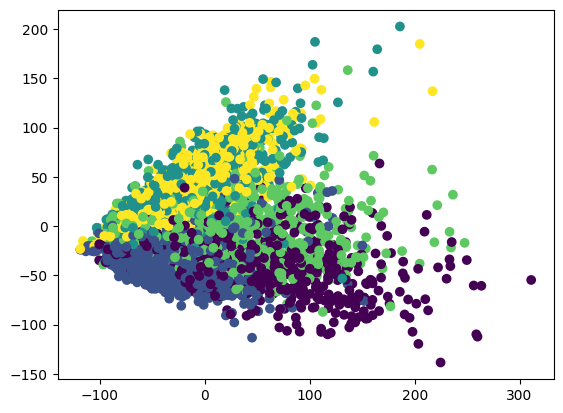

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

## MLP Classifier (helper code)


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                raise NotImplementedError
        return self

    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        raise NotImplementedError

## Autoencoder (helper code)

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


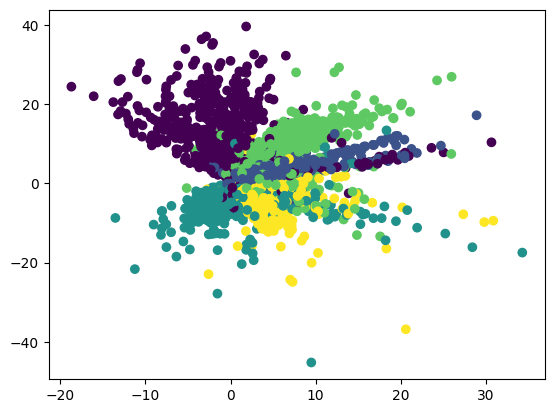

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

## Question 19 - 21

**<font color=blue size=4>Question 19**

**- In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?**

Although the VGG network is trained on a dataset with perhaps totally different classes as targets, one can expect the features derived from such a network to have discriminative power for a custom dataset. The first reason is hierarchical learning. Deep learning models learn to recognize patterns in a hierarchical manner. Initially layers learn only generic and simple features. Subsequent layers combine these. The final layer may detect entire objects or scenes. And the most important concept here is feature transferability. Lower and mid-level features are usually not specific to the dataset they were trained on, but rather are generic features common to many visual tasks. This means that patterns learned from one dataset are still relevant to new datasets. Additionally, fine-tuning is often performed when applying pre-trained models to customized datasets. This involves continuing the training process on the new dataset, allowing the model to adjust higher-level features to better fit the new category, but the lower-level features learned from the original dataset are still useful. Also, pre-trained models have typically been exposed to a large amount of diverse data. When you use such a model on a custom dataset, the diversity of learned features can serve as a form of data enhancement. Finally, models like VGG have been trained on a wide class of datasets and learned a wide set of features. But such learned features are applicable to many new datasets.

**<font color=blue size=4>Question 20**

**- In a brief paragraph explain how the helper code base is performing feature
extraction.**

The process works as follows:


*   The first step is to download the dataset. If there is no local flower dataset, we need to download and decompress the images from a specified link.
*   Then a new class FeatureExtractor is defined, which inherits the pre-trained VGG16 model, e.g., retaining the VGG16 convolutional layers (features), the average pooling layer (pooling) and the first fully connected layer (fc). These layers are assembled into a sequential model that will output a feature vector when given an input image.

*   The next step is to initialize the feature extraction model and move it to the GPU to accelerate the computation.

*   The 'ImageFolder' dataset is then loaded with images from a catalog and transformations such as resizing, cropping, and normalizing are utilized to match the input. The data is then batch processed by 'dataloader'.
*   Then use a loop for feature extraction. For each batch, it will call'feature_extractor' model to compute feature vectors. Then transfer the features from GPU to CPU. Then appends the computed feature vectors (f_all) and their corresponding labels (y_all) to arrays meant to hold all features and labels, respectively.


*   Finally, when all the features are extracted, they are saved to disk in a compressed. 'npz' file.





**<font color=blue size=4>Question 21**

**- How many pixels are there in the original images? How many features does
the VGG network extract per image; i.e what is the dimension of each feature vector for an image
sample?**

In the original dataset, I found that the original images have different pixel height and pixel width. In this case, I can not give the accurate pixels of the original images. But there is "transforms.Compose" and resize all images to the same size, which is 224 * 224. So for each image, there are 224 * 224 = 50176 pixels. Also, the VGG network extract 4096 features per image.

## Question 22

In [ ]:
num_non_zero = np.count_nonzero(f_all)

print("Number of non-zero elements in the feature vector:", num_non_zero)

Number of non-zero elements in the feature vector: 15032320


**<font color=blue size=4>Question 22**

**- Are the extracted features dense or sparse? (Compare with sparse TF-IDF
features in text.)**

The extracted features are dense compare with sparse TF-IDF features in text. This is because most of the elements in the feature vector are non-zero due to the continuous nature of the image data and the convolution process that combines pixel information in a complex way. We can know from the code that the non-zero features for VGG are 15032320, which means there are non zero features. The features are sparse in TF-IDF. Since most of the elements in the feature vector are zero, this is because any given document uses only a small fraction of the words from the vocabulary.

## Question 23

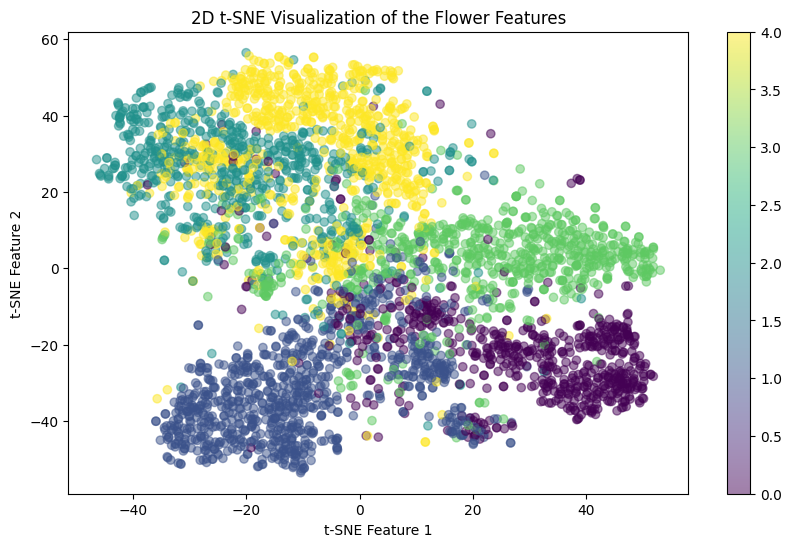

In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
f_all_2d = tsne.fit_transform(f_all)

# Plot the 2D features
plt.figure(figsize=(10, 6))
scatter = plt.scatter(f_all_2d[:, 0], f_all_2d[:, 1], c=y_all, cmap='viridis', alpha=0.5)

# Create a color bar
plt.colorbar()

# Label the axes and create a title
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('2D t-SNE Visualization of the Flower Features')

# Show the plot
plt.show()

**<font color=blue size=4>Question 23**

**- In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf
choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with
t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with
ground-truth labels. Describe your observation.**

Initially, the data points have been clustered by the t-SNE algorithm into multiple separate groups, indicating that the high-dimensional characteristics have patterns that are visible in two dimensions. These clusters can be associated with various flower types seen in the dataset. Also, the fact that comparable colored data points are typically clustered together with similar labels suggests that t-SNE has successfully captured the underlying structure of the data as well as the connections between various classes. And there is some degree of overlapping between clusters of different colors. The reason may be the inherent similarity between certain classes of flowers, which makes them less distinguishable in the feature space. Also, there is a small number of data points are located distantly from their primary clusters. These outliers may result from data abnormalities, incorrectly tagged examples, or unusual variances within a class. At last, while some clusters seem more sparse, others seem denser, with a higher concentration of data points. Denser clusters may have less variance, which could be a reflection of the variance within each class.




## Question 24

In [ ]:
config = {
        'None': None,
        'SVD': TruncatedSVD(n_components= 50),
        'UMAP': umap.UMAP(n_components= 50, metric= 'cosine'),
        'Autoencoder': Autoencoder(n_components = 50)
}

q_24_df = pd.DataFrame(columns=['Dimensionality Reduction', 'Clustering', 'Adjusted Rand Score'])

In [ ]:
start = time.time()
for dr_name, dr_model in config.items():
  if dr_model is not None:
    print('Fitting ' + dr_name)
    X_reduced = dr_model.fit_transform(f_all)
  else:
    X_reduced = f_all
    print('Fitting no dimension reduction method...')

  #KMeans
  kmeans = KMeans(n_clusters=5, random_state=3, max_iter = 1000, n_init = 30)
  print(f'Fitting KMeans with n_clusters = 5')
  kmeans.fit(X_reduced)
  labels_pred = kmeans.labels_
  adj_rand_score = adjusted_rand_score(y_all, labels_pred)
  q_24_df = q_24_df.append({
                      'Dimensionality Reduction': dr_name,
                      'Clustering': 'KMeans',
                      'Adjusted Rand Score': adj_rand_score,
                  }, ignore_index=True)

  #Aggomerative Clustering
  clustering = AgglomerativeClustering(n_clusters = 5, linkage = 'ward').fit(X_reduced)
  print(f'Fitting Aggomerative with n_clusters = 5')
  labels_pred = clustering.labels_
  adj_rand_score = adjusted_rand_score(y_all, labels_pred)
  q_24_df = q_24_df.append({
                      'Dimensionality Reduction': dr_name,
                      'Clustering': 'Aggomerative Clustering',
                      'Adjusted Rand Score': adj_rand_score,
                  }, ignore_index=True)

end = time.time()
print(end - start)

Fitting no dimension reduction method...
Fitting KMeans with n_clusters = 5
Fitting Aggomerative with n_clusters = 5
Fitting SVD
Fitting KMeans with n_clusters = 5
Fitting Aggomerative with n_clusters = 5
Fitting UMAP
Fitting KMeans with n_clusters = 5
Fitting Aggomerative with n_clusters = 5
Fitting Autoencoder


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


Fitting KMeans with n_clusters = 5
Fitting Aggomerative with n_clusters = 5
205.39365148544312


In [ ]:
start = time.time()
for dr_name, dr_model in config.items():
  if dr_model is not None:
    print('Fitting ' + dr_name)
    X_reduced = dr_model.fit_transform(f_all)
  else:
    X_reduced = f_all
    print('Fitting no dimension reduction method...')

  for min_c_size in [100, 200, 500]:
    for samples in [5, 10, 20]:
      hdb = hdbscan.HDBSCAN(min_cluster_size=min_c_size, min_samples = samples).fit(X_reduced)
      labels_pred = hdb.labels_
      adj_rand_score = adjusted_rand_score(y_all, labels_pred)
      q_24_df = q_24_df.append({
                      'Dimensionality Reduction': dr_name,
                      'Clustering': 'HDBSCAN',
                      'Adjusted Rand Score': adj_rand_score,
                  }, ignore_index=True)
end = time.time()
print(end - start)

Fitting no dimension reduction method...
Fitting SVD
Fitting UMAP
Fitting Autoencoder


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


1215.6716849803925


In [ ]:
q_24_df

Dimensionality Reduction               Clustering  Adjusted Rand Score
0                      None                   KMeans             0.189043
1                      None  Aggomerative Clustering             0.218450
2                       SVD                   KMeans             0.193849
3                       SVD  Aggomerative Clustering             0.169834
4                      UMAP                   KMeans             0.467690
5                      UMAP  Aggomerative Clustering             0.426631
6               Autoencoder                   KMeans             0.278006
7               Autoencoder  Aggomerative Clustering             0.259897
8                      None                  HDBSCAN             0.000000
9                      None                  HDBSCAN             0.000000
10                     None                  HDBSCAN             0.000000
11                     None                  HDBSCAN             0.000000
12                     None                  HDBSCAN             0.000000
13                     None                  HDBSCAN             0.000000
14                     None                  HDBSCAN             0.000000
15                     None                  HDBSCAN             0.000000
16                     None                  HDBSCAN             0.000000
17                      SVD                  HDBSCAN             0.000000
18                      SVD                  HDBSCAN             0.000000
19                      SVD                  HDBSCAN             0.000000
20                      SVD                  HDBSCAN             0.000000
21                      SVD                  HDBSCAN             0.000000
22                      SVD                  HDBSCAN             0.000000
23                      SVD                  HDBSCAN             0.000000
24                      SVD                  HDBSCAN             0.000000
25                      SVD                  HDBSCAN             0.000000
26                     UMAP                  HDBSCAN             0.094525
27                     UMAP                  HDBSCAN             0.094525
28                     UMAP                  HDBSCAN             0.094525
29                     UMAP                  HDBSCAN             0.094525
30                     UMAP                  HDBSCAN             0.094525
31                     UMAP                  HDBSCAN             0.094525
32                     UMAP                  HDBSCAN             0.094525
33                     UMAP                  HDBSCAN             0.094525
34                     UMAP                  HDBSCAN             0.094525
35              Autoencoder                  HDBSCAN             0.000000
36              Autoencoder                  HDBSCAN             0.000000
37              Autoencoder                  HDBSCAN             0.000000
38              Autoencoder                  HDBSCAN             0.000000
39              Autoencoder                  HDBSCAN             0.000000
40              Autoencoder                  HDBSCAN             0.000000
41              Autoencoder                  HDBSCAN             0.000000
42              Autoencoder                  HDBSCAN             0.000000
43              Autoencoder                  HDBSCAN             0.000000

**<font color=blue size=4>Question 24**

**- Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.**

The best clustering results is Kmeans with UMAP, which is 0.468. You can see the results as followings:

|   | k-means |Agglomerative Clustering|HDBSCAN
| ----------------  | ------   |------|------|
| SVD|0.194|0.170 |0  |   
| UMAP| **0.468**|0.427|0.095|
| Autoencoder| 0.278|0.260|0|

For HDBSCAN, we tried min_c_size in [100, 200, 500] and samples in [5, 10, 20].


## Question 25

In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 9.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=4041f7a0346f04f769f5e75853d9461746b8144592686bcca9416449af770257
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import numpy as np
# import umap
import umap.umap_ as umap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

# Reduce dimensionality of the training features using UMAP
umap_reducer = umap.UMAP(n_components=50, random_state=42)
X_train_reduced = umap_reducer.fit_transform(X_train)
X_test_reduced = umap_reducer.transform(X_test)

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                optimizer.zero_grad()
                outputs = self(X_)
                loss = criterion(outputs, y_)
                loss.backward()
                optimizer.step()
        return self

    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()

        with torch.no_grad():
            outputs = self(X_test)
            _, predicted = torch.max(outputs.data, 1)
            total = y_test.size(0)
            correct = (predicted == y_test).sum().item()

        return correct / total

# Initialize the MLP classifier for original features
mlp_original = MLP(num_features=f_all.shape[1]).cuda()

# Train the MLP classifier on the original features
mlp_original.train(X_train, y_train)

# Evaluate the MLP classifier on the original features
accuracy_original = mlp_original.eval(X_test, y_test)
print(f"Accuracy with original features: {accuracy_original * 100:.2f}%")

# Initialize the MLP classifier for reduced features
mlp_reduced = MLP(num_features=50).cuda()

# Train the MLP classifier on the UMAP-reduced features
mlp_reduced.train(X_train_reduced, y_train)

# Evaluate the MLP classifier on the UMAP-reduced features
accuracy_reduced = mlp_reduced.eval(X_test_reduced, y_test)
print(f"Accuracy with UMAP-reduced features: {accuracy_reduced * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


Accuracy with original features: 89.92%


100%|██████████| 100/100 [00:05<00:00, 16.67it/s]

Accuracy with UMAP-reduced features: 79.97%


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

class Autoencoder(nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

n_components = 50
autoencoder = Autoencoder(n_components=n_components).cuda()

# Train the Autoencoder
autoencoder.fit(X_train)

# Transform the training and test sets
X_train_reduced = autoencoder.transform(X_train)
X_test_reduced = autoencoder.transform(X_test)

class MLP(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                optimizer.zero_grad()
                outputs = self(X_)
                loss = criterion(outputs, y_)
                loss.backward()
                optimizer.step()
        return self

    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()

        with torch.no_grad():
            outputs = self(X_test)
            _, predicted = torch.max(outputs.data, 1)
            total = y_test.size(0)
            correct = (predicted == y_test).sum().item()

        return correct / total

# Initialize the MLP classifier for reduced features
mlp_reduced = MLP(num_features=n_components).cuda()

# Train the MLP classifier on the Autoencoder-reduced features
mlp_reduced.train(X_train_reduced, y_train)

# Evaluate the MLP classifier on the Autoencoder-reduced features
accuracy_reduced = mlp_reduced.eval(X_test_reduced, y_test)
print(f"Accuracy with Autoencoder-reduced features: {accuracy_reduced * 100:.2f}%")


100%|██████████| 100/100 [00:05<00:00, 18.65it/s]

Accuracy with Autoencoder-reduced features: 87.19%


**<font color=blue size=4>Question 25**

**- Report the test accuracy of the MLP classifier on the original VGG features.
Report the same when using the reduced-dimension features (you have freedom in choosing the
dimensionality reduction algorithm and its parameters). Does the performance of the model suffer
with the reduced-dimension representations? Is it significant? Does the success in classification
make sense in the context of the clustering results obtained for the same features in Question 24.**

We tried MLP with Autoencoder and UMAP, the accuracy as follows:

*   Accuracy with original features: 89.92%

*   Accuracy with Autoencoder-reduced features (n = 50): 87.19%
*   Accuracy with UMAP-reduced features (n = 50): 79.97%

The performance of the model suffer with the reduced-dimension representations. For Autoencoder, it is not significant. It only drops almost 3%. But for UMAP, it is significant. It drops almost 10%. The success in classification does not make sense in the context of the clustering results obtained for the same features in Question 24.

# Part 3 - Clustering using both image and text



In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_7m1bsuq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_7m1bsuq
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=126cba77151582a17ca463b7e6eff

In [ ]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

### Question 26

In [ ]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [ ]:
!unzip archive.zip

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def find_top_pokemon(pokedex, image_embeddings, text_query, model, preprocess, device, top_n=5):
    # Generate text embeddings for the query
    text_embeddings = clip_inference_text(model, preprocess, [text_query], device)

    # Compute similarity scores
    similarity = compute_similarity_image_to_text(image_embeddings, text_embeddings)

    # Get indices of top matching Pokémon
    top_indices = np.argsort(similarity[:, 0])[::-1][:top_n]

    # Return the top Pokémon and their similarities
    return pokedex.iloc[top_indices], similarity[top_indices, 0]

def plot_top_pokemon(top_pokemon, similarities, query):
    fig, axes = plt.subplots(1, len(top_pokemon), figsize=(20, 4))
    fig.suptitle(query, fontsize=20)

    for ax, (index, pokemon), similarity in zip(axes, top_pokemon.iterrows(), similarities):
        img_path = pokemon['image_path']
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        title = f"{pokemon['Name']}\nType1: {pokemon['Type1']}"
        if pd.notna(pokemon['Type2']):
            title += f", Type2: {pokemon['Type2']}"
        ax.set_title(f"{title}\nScore: {similarity:.2f}", fontsize=15)

    plt.tight_layout()
    plt.show()

In [ ]:
pokedex = construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/')
model, preprocess, device = load_clip_model()

100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 81.9MiB/s]


In [ ]:
image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"].tolist(), device)

100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 83.3MiB/s]
100%|██████████| 753/753 [00:17<00:00, 42.58it/s]


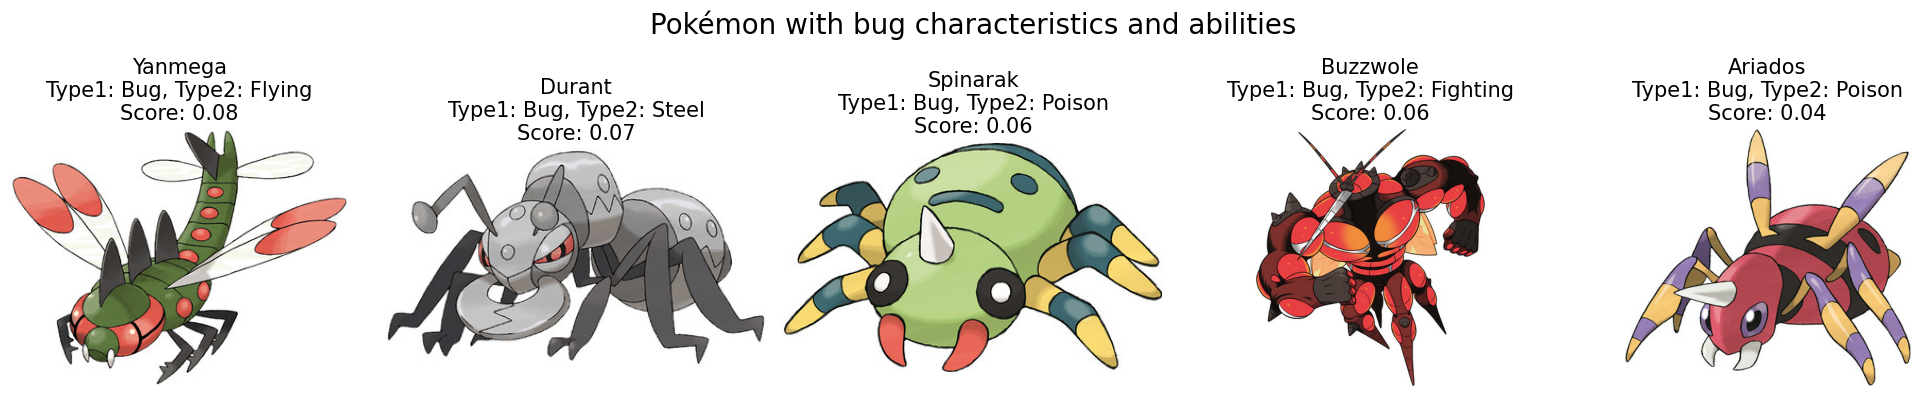

In [ ]:
query = "Pokémon with bug characteristics and abilities"
top_pokemon, similarities = find_top_pokemon(pokedex, image_embeddings, query, model, preprocess, device)
plot_top_pokemon(top_pokemon, similarities, query)

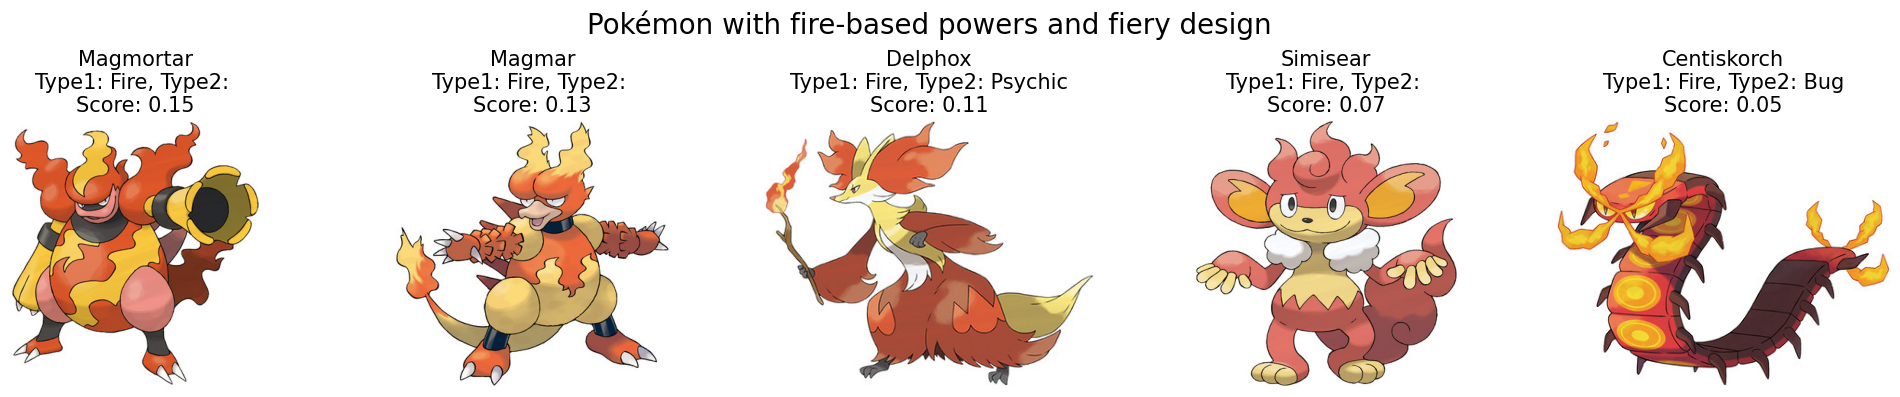

In [ ]:
query = "Pokémon with fire-based powers and fiery design"
top_pokemon, similarities = find_top_pokemon(pokedex, image_embeddings, query, model, preprocess, device)
plot_top_pokemon(top_pokemon, similarities, query)

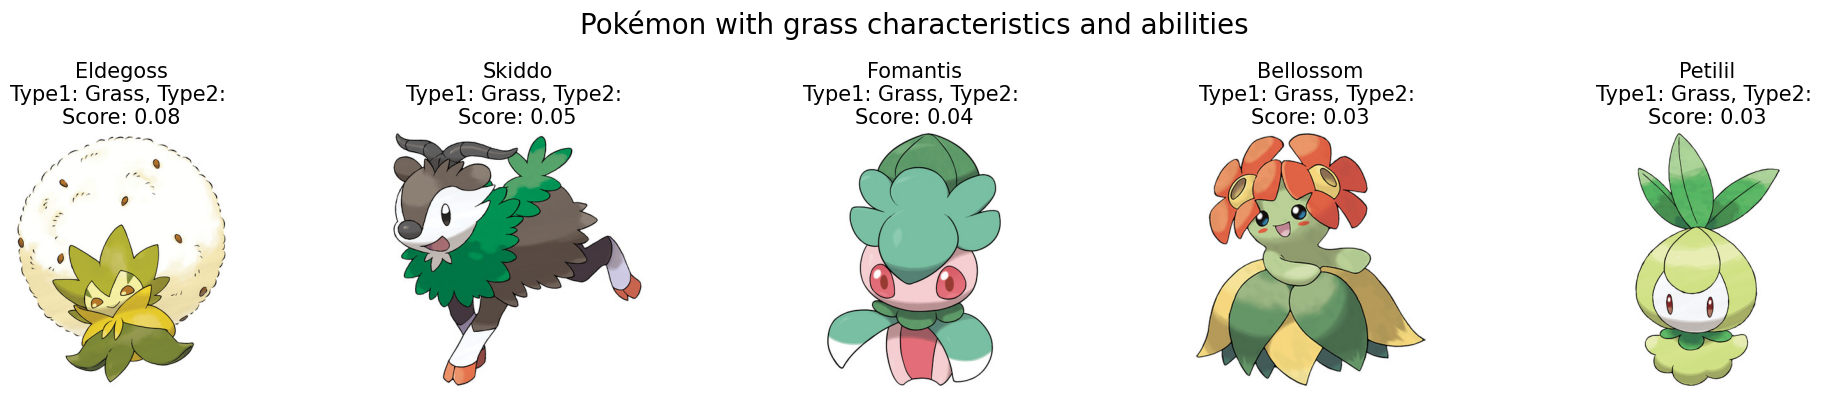

In [ ]:
query = "Pokémon with grass characteristics and abilities"
top_pokemon, similarities = find_top_pokemon(pokedex, image_embeddings, query, model, preprocess, device)
plot_top_pokemon(top_pokemon, similarities, query)

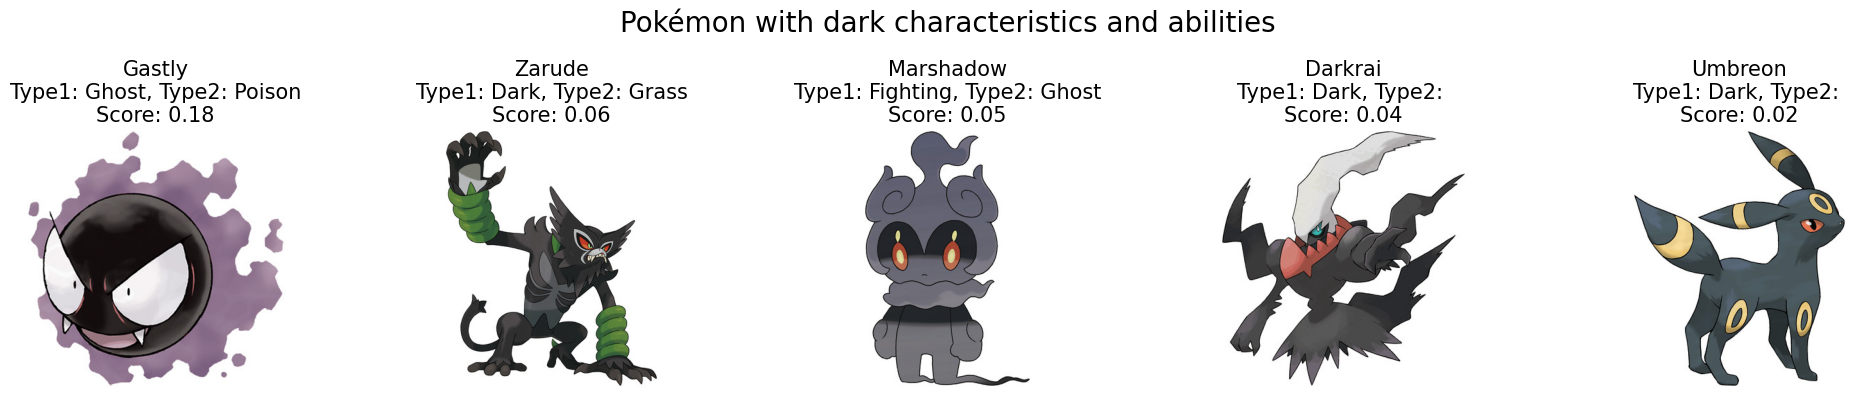

In [ ]:
query = "Pokémon with dark characteristics and abilities"
top_pokemon, similarities = find_top_pokemon(pokedex, image_embeddings, query, model, preprocess, device)
plot_top_pokemon(top_pokemon, similarities, query)

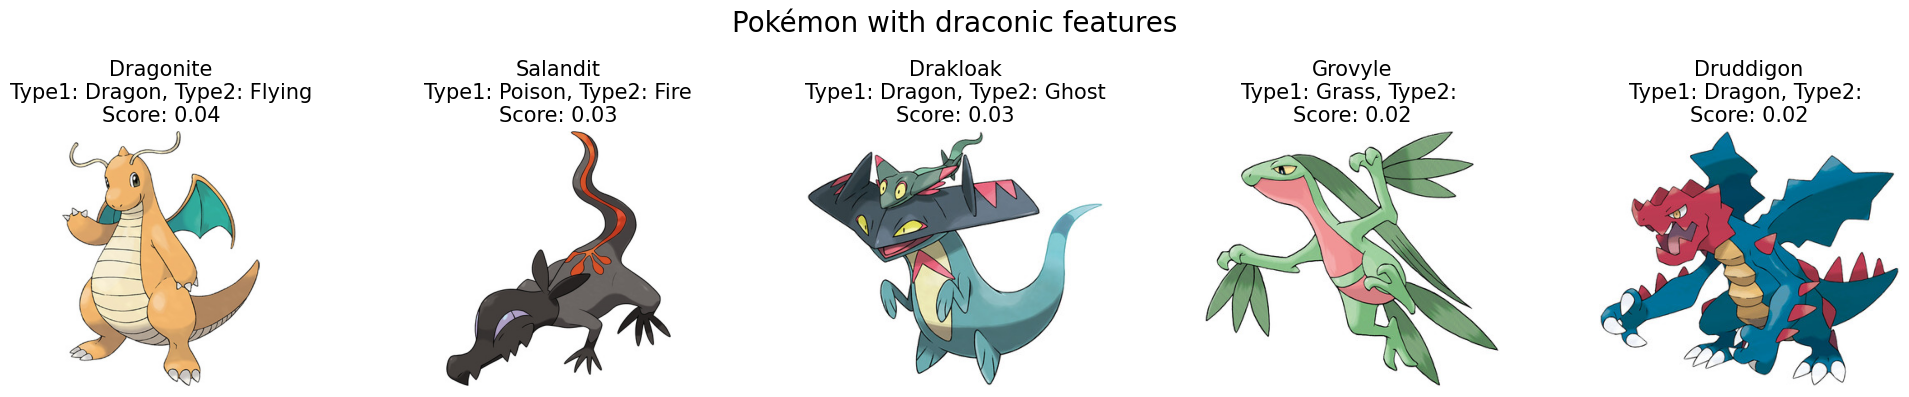

In [ ]:
query = "Pokémon with draconic features"
top_pokemon, similarities = find_top_pokemon(pokedex, image_embeddings, query, model, preprocess, device)
plot_top_pokemon(top_pokemon, similarities, query)

**<font color=blue size=4>Question 26**

**- Try to construct various text queries regarding types of Pokemon (such as ”type:
Bug”, ”electric type Pokemon” or ”Pokemon with fire abilities”) to find the relevant images from
the dataset. Once you have found the most suitable template for queries, please find the top five
most relevant Pokemon for type Bug, Fire and Grass. For each of the constructed query, please plot
the five most relevant Pokemon horizontally in one figure with following specifications:**

**• the title of the figure should be the query you used;**

**• the title of each Pokemon should be the name of the Pokemon and its first and second type.**

**- Repeat this process for Pokemon of Dark and Dragon types. Assess the effectiveness of your queries
in these cases as well and try to explain any differences.**


I tried 5 different text queries for type Bug, Fire, Grass, Dark, and Dragon. And I plot the five most relevant Pokemon horizontally in one figure. You can see them above. For type Bug, the query is effective. These five Pokemons' first type are all Bug. So there are the most revelant. For type Fire, the query is effective. These five Pokemons' first type are all Fire. So there are the most revelant. For type Grass, the query is effective. These five Pokemons' first type are all Grass. So there are the most revelant. For type Dark, the efficiency for the query is decrease. There are three Pokemons' first type are Dark. And one is ghost and one is fighting. So the efficiency is decrease. For type Dragon, the query is also not efficiency. There are three Pokemons' first type are Dragon. And one is poison, and one is grass. So the efficiency is decrease. It is possible that this is misleading because of the shape of the image. There are a lot of Pokemon with attributes that are not dark and dragon, but they have the appearance of dark and dragon. So it is possible that they have been misclassified. This reason can be clearly found in the images.

### Question 27

In [ ]:
from random import sample

In [ ]:
def select_random_pokemon(pokedex, image_embeddings, n=10):
  random_indices = sample(range(len(pokedex)), n)
  selected_pokedex = pokedex.iloc[random_indices]
  selected_embeddings = image_embeddings[random_indices]
  return selected_pokedex, selected_embeddings

In [ ]:
queries_dict = {
    'Grass': "Pokémon with plant-based abilities and grassy design",
    'Fire': "Pokémon with fire-based powers and fiery design",
    'Water': "Pokémon with water-based abilities and aquatic design and looks like a sea animal",
    'Bug': "Pokémon with insect-like features and bug-type moves",
    'Normal': "Pokémon with standard abilities and a typical appearance",
    'Poison': "Pokémon with toxic abilities and a venomous design",
    'Fairy': "Pokémon with magical fairy-like abilities and enchanting design",
    'Fighting': "Pokémon with martial arts skills and a strong fighter design",
    'Psychic': "Pokémon with telepathic powers and a mystical psychic design",
    'Electric': "Pokémon with electric abilities and a sparky design",
    'Ghost': "Pokémon with ghostly powers and a spectral design",
    'Rock': "Pokémon with stone-based abilities and a rocky design",
    'Ground': "Pokémon with earth-based abilities and a terrestrial design",
    'Ice': "Pokémon with chilling abilities and an icy design",
    'Dragon': "Pokémon with draconian features and dragon-type powers",
    'Dark': "Pokémon with shadowy abilities and a dark design",
    'Steel': "Pokémon with metal-based abilities and a steel design",
    'Flying': "Pokémon with abilities to soar and a flying design"
}

In [ ]:
all_type_probs = []
type_queries = list(queries_dict.values())
type_embeddings = clip_inference_text(model, preprocess, type_queries, device)
for i, row in selected_pokedex.reset_index().iterrows():
  pokemon_embedding = selected_embeddings[i]
  similarities = compute_similarity_text_to_image(pokemon_embedding, type_embeddings)
  prob_dict = dict(zip(queries_dict.keys(), similarities))
  all_type_probs.append(prob_dict)
sorted_probs = [dict(sorted(probs.items(), key = lambda x: x[1], reverse = True)) for probs in all_type_probs]

In [ ]:
for i, row in selected_pokedex.reset_index().iterrows():
  pokemon_image = Image.open(row['image_path'])
  plt.figure(figsize=(5, 5))
  plt.imshow(pokemon_image)
  plt.title(f"{row['Name']} - {row['Type1']}, {row['Type2'] if pd.notna(row['Type2']) else 'None'}")
  plt.axis('off')

  probs = sorted_probs[i]
  top_types = list(probs.keys())[:5]
  top_probabilities = list(probs.values())[:5]
  plt.figure(figsize=(10, 2))
  bars = plt.barh(top_types, top_probabilities, color='skyblue')
  plt.xlabel('Probability')
  plt.title('Top 5 Predicted Types by CLIP')

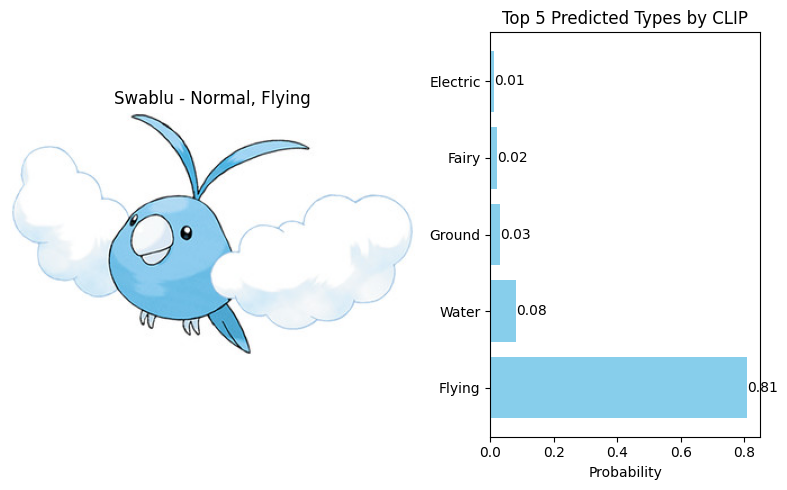

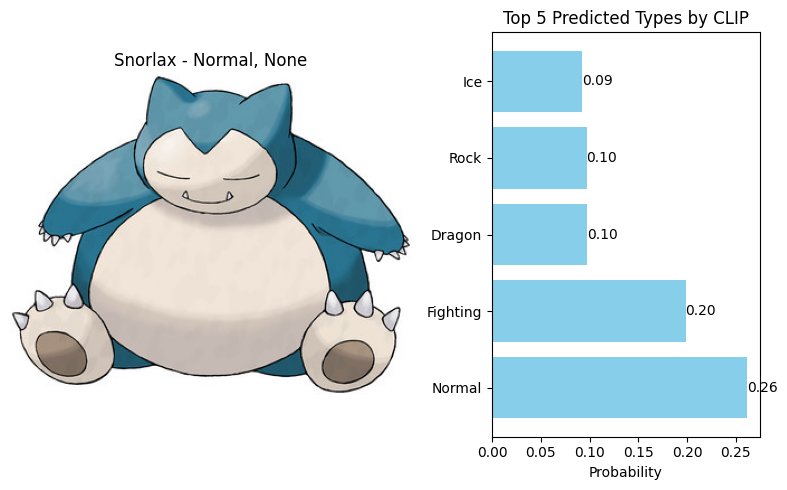

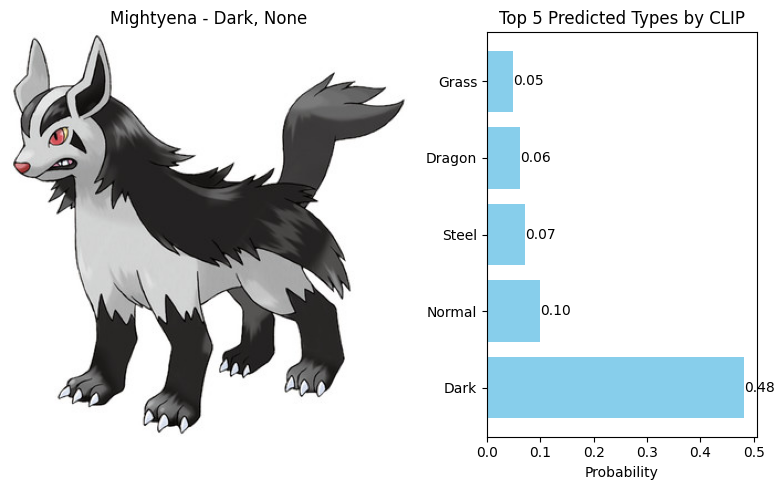

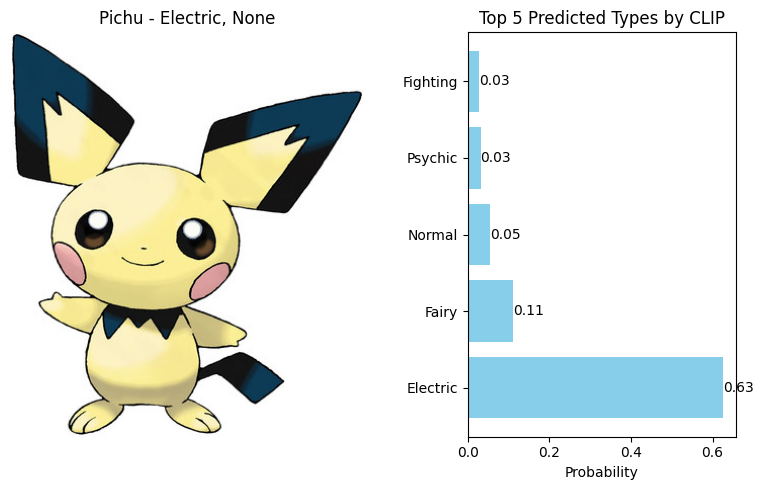

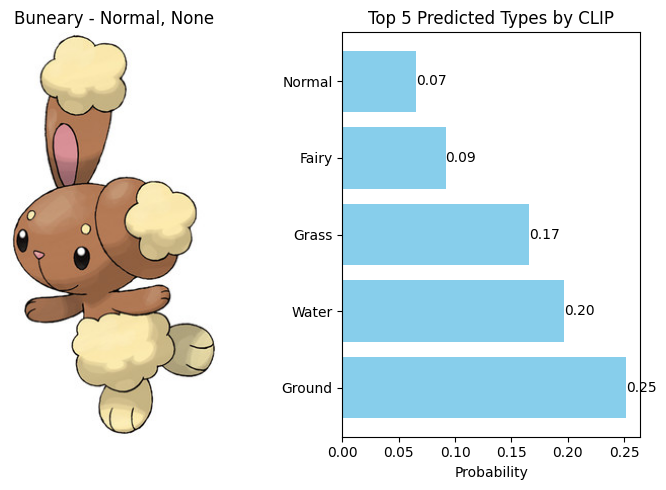

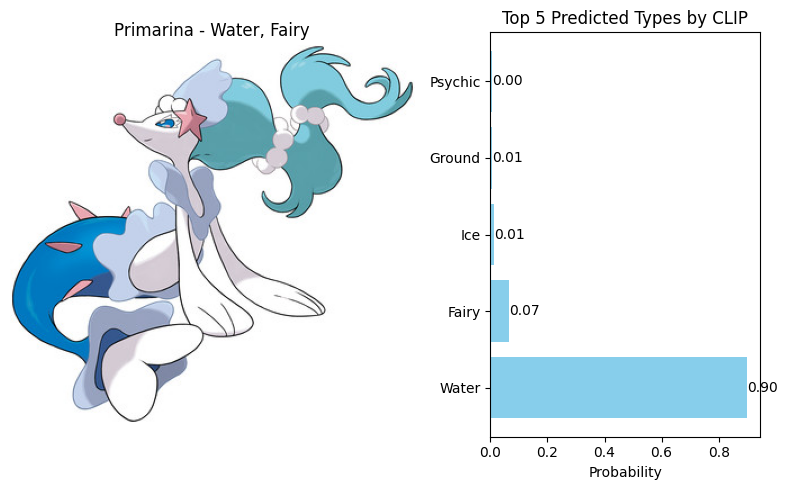

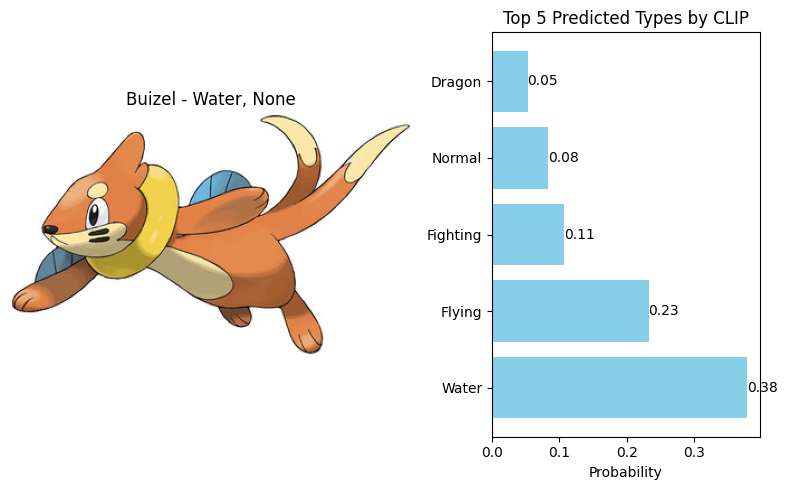

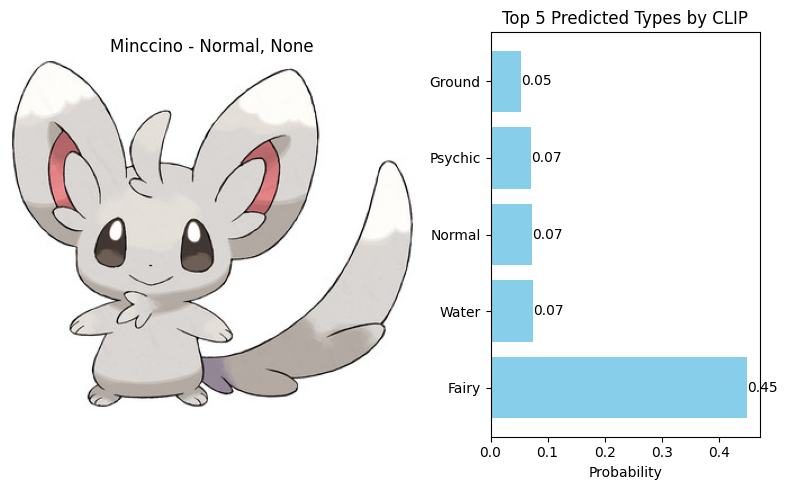

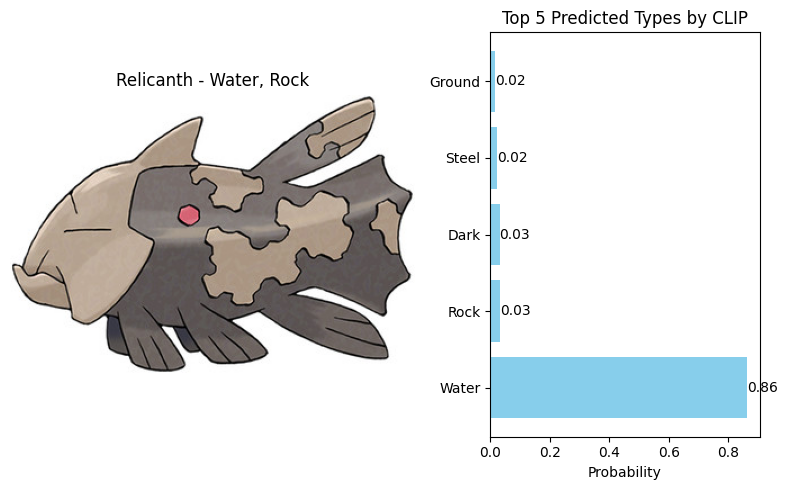

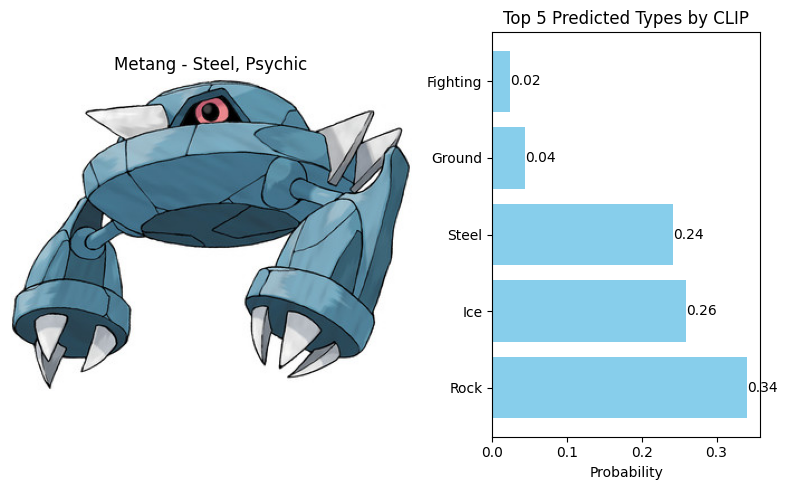

In [ ]:
for i, row in selected_pokedex.reset_index().iterrows():
  fig, axs = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [3, 2]})
  pokemon_image = Image.open(row['image_path'])
  axs[0].imshow(pokemon_image)
  axs[0].set_title(f"{row['Name']} - {row['Type1']}, {row['Type2'] if pd.notna(row['Type2']) else 'None'}")
  axs[0].axis('off')

  probs = sorted_probs[i]
  top_types = list(probs.keys())[:5]
  top_probabilities = list(probs.values())[:5]
  bars = axs[1].barh(top_types, top_probabilities, color='skyblue')
  axs[1].set_xlabel('Probability')
  axs[1].set_title('Top 5 Predicted Types by CLIP')

  for bar, prob in zip(bars, top_probabilities):
        axs[1].text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                    f'{prob:.2f}',
                    va='center', ha='left')

  plt.tight_layout()
  plt.show()

**<font color=blue size=4>Question 27**

**- Randomly select 10 Pokemon images from the dataset and use CLIP to find the
most relevant types (use your preferred template, e.g ”type: Bug”). For each selected Pokemon,
please plot it and indicate:**

**• its name and first and second type;**

**• the five most relevant types predicted by CLIP and their predicted probabilities.**

We already plot the Pokemon with name and first and second type and five most relevant types predicted by CLIP and probabilities. You can see them above.


### Question 28

In [ ]:
pokedex = pd.read_csv('pokedex.csv')
image_embedding = np.load('image_embedding.npy')

In [ ]:
filtered_pokedex = pokedex[pokedex['Type1'].isin(['Bug', 'Fire', 'Grass'])]
filtered_embeddings = image_embedding[filtered_pokedex.index]
tsne_results = umap_projection(filtered_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine')

In [ ]:
plot_data = pd.DataFrame(tsne_results, columns=['x', 'y'])
plot_data['Pokemon Name'] = filtered_pokedex['Name'].values
plot_data['Type1'] = filtered_pokedex['Type1'].values
plot_data['Type2'] = filtered_pokedex['Type2'].values
plot_data['hover_text'] = plot_data['Pokemon Name'] + ' - ' + plot_data['Type1']

fig = px.scatter(plot_data, x='x', y='y',
                 color='Type1',
                 hover_name='hover_text',
                 title='t-SNE Visualization of Pokemon Images (Types: Bug, Fire, Grass)')
fig.show()

**<font color=blue size=4>Question 28**

**- In the first and second question, we investigated how CLIP creates ’clusters’ by
mapping images and texts of various Pokemon into a high-dimensional space and explored neighborhood of these items in this space. For this question, please use t-SNE to visualize image clusters,
specifically for Pokemon types Bug, Fire, and Grass. You can use scatter plot from python package
plotly. For the visualization, color-code each point based on its first type type 1 using the ’color’
argument, and label each point with the Pokemon’s name and types using ’hover name’. This
will enable you to identify each Pokemon represented in your visualization. After completing the
visualization, analyze it and discuss whether the clustering of Pokemon types make sense to you.**

There are some observations about the visualization:



*   Cluster Separation: The picture embeddings appear to contain different features that correlate to the individual Pokémon types, as evidenced by the reasonably well-separated clusters for each type of Pokémon.

*   Cluster Overlap: There is some overlap among the clusters, especially the types of Grass and Bug. This could be as a result of the shared characteristics these Pokémon have.

*   Distinct Fire Type Cluster: Compared to the other two types, fire-type Pokémon are typically more recognizable and isolated. This may be explained by the distinct fiery color scheme and characteristics of Pokémon of the Fire type, which differ significantly from those of the Bug and Grass types.


*   Outliers: Some of the locations are distant from their primary cluster. These might be Pokémon with unique characteristics that set them apart from their "Type 1" counterparts.


The clustering of Pokemon types make sense to us. As mentioned above, there will be some overlap between the different clusters, probably because Pokemon has two different attributes. When we went to check out the information on Pokemon, this verified our thoughts. So it makes sense.




